In [1]:
import sys
import os
import importlib
from   pathlib      import Path
import traceback

import numpy                as np
import matplotlib           as mpl
import matplotlib.pyplot    as plt
import seaborn              as sns
import pandas               as pd

from scipy.stats    import kruskal, wilcoxon, mannwhitneyu, ranksums
from scipy.optimize import curve_fit
from lmfit import Model, Parameters

from eidynamics     import utils, plot_tools
from eidynamics     import pattern_index
import all_cells

sns.set_context('paper')
%matplotlib widget
%tb

# make a colour map viridis
viridis = mpl.colormaps["viridis"]
flare   = mpl.colormaps["flare"]
crest   = mpl.colormaps["crest"]
magma   = mpl.colormaps["magma"]
edge    = mpl.colormaps['edge']
rocket_r    = mpl.colormaps['rocket_r']

color_E = flare
color_I = crest
color_freq = {1:magma(0.05), 5:magma(0.1), 10:magma(0.2), 20:magma(.4), 30:magma(.5), 40:magma(.6), 50:magma(.7), 100:magma(.9)}
color_squares = {1:viridis(0.2), 5:viridis(.4), 7:viridis(.6), 15:viridis(.8), 20:viridis(1.0)}
color_squares_r = {1:rocket_r(0.2), 5:rocket_r(.4), 7:rocket_r(.6), 15:rocket_r(.8), 20:rocket_r(1.0)}
color_EI = {-70:flare(0), 0:crest(0)}
color_cells = mpl.colormaps['tab10']
Fs = 2e4

freq_sweep_pulses = np.arange(9)

>> Working on:  C:\Users\adity\OneDrive\NCBS


No traceback available to show.


In [2]:
def sdnfunc(observed, gamma):
    return gamma * observed / (gamma + observed)

def nosdn(observed, m):
    return m * observed

In [3]:
figure_raw_material_location = Path(r"paper_figure_matter\\")
paper_figure_export_location = Path(r"paper_figures\\Figure3v4\\")
data_path_FS                 = Path(r"parsed_data\\FreqSweep\\")
data_path_LTM                 = Path(r"parsed_data\\LTMRand\\")
data_path_grid               = Path(r"parsed_data\\Grid\\")
data_path_analysed           = Path(r"parsed_data\\second_order\\")
raw_data_path_cellwise       = Path(r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\EI_Dynamics\Data\Screened_cells\\")

### Load the CC data and screen

In [4]:
# Update September 2024
# September 2024
# short data path that contains the kernel fit data for FreqSweep protocol, also contains the field p2p data. latest and checked. Use this for all freqsweep measurements.
# Contains screening parameters also.
# 18Sep24
CC_FS_shortdf_withkernelfit_datapath = data_path_FS / "all_cells_FreqSweep_CC_kernelfit_response_measurements.h5"
cc_FS_shortdf = pd.read_hdf(CC_FS_shortdf_withkernelfit_datapath, key='data')
print(cc_FS_shortdf.shape)

CC_LTM_shortdf_withkernelfit_datapath = data_path_LTM / "all_cells_LTM_CC_kernelfit_response_measurements_noNANs.h5"
cc_LTM_shortdf = pd.read_hdf(CC_LTM_shortdf_withkernelfit_datapath, key='data')
print(cc_LTM_shortdf.shape)

cc_FS_LTM_shortdf = pd.concat([cc_FS_shortdf, cc_LTM_shortdf], axis=0, ignore_index=True)
# reset index
cc_FS_LTM_shortdf.reset_index(drop=True, inplace=True)

(4971, 163)
(539, 163)


In [5]:
# Data screening
# CC data screening based on dataflag_fields: protocol freqsweep
cc_FS_LTM_shortdf_slice = cc_FS_LTM_shortdf[
                                            (cc_FS_LTM_shortdf['location'] == 'CA1') &
                                            (cc_FS_LTM_shortdf['numSq'].isin([1,5,7,15])) &
                                            (cc_FS_LTM_shortdf['stimFreq'].isin([20,30,40,50])) &
                                            (cc_FS_LTM_shortdf['condition'] == 'Control') &
                                            (cc_FS_LTM_shortdf['ch0_response']==1) &
                                            (cc_FS_LTM_shortdf['IR'] >50) & (cc_FS_LTM_shortdf['IR'] < 400) &
                                            (cc_FS_LTM_shortdf['tau'] < 40) & 
                                            # (cc_FS_LTM_shortdf['probePulseStart']==0.2) &
                                            # (cc_FS_LTM_shortdf['intensity']==100) &
                                            # (cc_FS_LTM_shortdf['pulseWidth']==2) &
                                            (cc_FS_LTM_shortdf['spike_in_baseline_period'] == 0) &
                                            (cc_FS_LTM_shortdf['ac_noise_power_in_ch0'] < 40)
                                            ]
print(cc_FS_LTM_shortdf.shape, '--screened-->', cc_FS_LTM_shortdf_slice.shape)
screened_cc_trialIDs = cc_FS_LTM_shortdf_slice['trialID'].unique()

# save trial IDs as a numpy array text file, all trialID are strings
np.savetxt(paper_figure_export_location / "Figure3_screened_trialIDs_CC_FS_LTM.txt", screened_cc_trialIDs, fmt='%s')

cc_FS_LTM_shortdf_slice['patternList'] = cc_FS_LTM_shortdf_slice['patternList'].astype('int32')
patternIDs = np.sort( cc_FS_LTM_shortdf_slice[cc_FS_LTM_shortdf_slice['numSq'] != 1]['patternList'].unique() )

print(f"Unique cells in screened data: { cc_FS_LTM_shortdf_slice['cellID'].nunique()}")
print(f"Unique sweeps in screened data: {cc_FS_LTM_shortdf_slice['trialID'].nunique()}")

# # take list stored in "peaks_field_norm" column and make it into new columns
cc_FS_LTM_shortdf_slice = utils.expand_list_column(cc_FS_LTM_shortdf_slice, 'peaks_field_norm', 'pfn_')

(5510, 163) --screened--> (3426, 163)
Unique cells in screened data: 22
Unique sweeps in screened data: 3426
input df shape:  (3426, 163) num of new columns:  9
new columns:  ['pfn_0', 'pfn_1', 'pfn_2', 'pfn_3', 'pfn_4', 'pfn_5', 'pfn_6', 'pfn_7', 'pfn_8'] 3426 9
(3426, 9) (3426, 172)


C:\Users\Aditya\AppData\Local\Temp\ipykernel_18348\512037211.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cc_FS_LTM_shortdf_slice['patternList'] = cc_FS_LTM_shortdf_slice['patternList'].astype('int32')


## Load the VC data and screen

In [6]:
VC_FS_shortdf_withkernelfit_datapath = data_path_FS / "all_cells_FreqSweep_VC_kernelfit_response_measurements.h5"
vc_FS_shortdf = pd.read_hdf(VC_FS_shortdf_withkernelfit_datapath, key='data')
print(vc_FS_shortdf.shape)

# save df
vc_FS_shortdf.to_hdf(VC_FS_shortdf_withkernelfit_datapath, key='data', mode='w')
# VC data screening
# VC data screening based on dataflag_fields
vc_FS_shortdf_slice = vc_FS_shortdf[
            (vc_FS_shortdf['location'] == 'CA1') &
            (vc_FS_shortdf['numSq'].isin([1,5,15])) &
            (vc_FS_shortdf['stimFreq'].isin([20,30,40,50])) &
            (vc_FS_shortdf['condition'] == 'Control') &
            (vc_FS_shortdf['ch0_response']==1) &
            # (vc_FS_shortdf['intensity'] == 100) &
            # (vc_FS_shortdf['pulseWidth'] == 2) &
            # (vc_FS_shortdf['probePulseStart']==0.2) &
            (vc_FS_shortdf['IR'] >40) & (vc_FS_shortdf['IR'] < 400) &
            (vc_FS_shortdf['tau'] < 40) & 
            (vc_FS_shortdf['ac_noise_power_in_ch0'] < 40)&
            (vc_FS_shortdf['valley_0'].notnull())
        ]
print(vc_FS_shortdf.shape, '--screened-->', vc_FS_shortdf_slice.shape)
screened_vc_trialIDs = vc_FS_shortdf_slice['trialID'].unique()
np.savetxt(paper_figure_export_location / "Figure3_screened_trialIDs_VC_FS.txt", screened_vc_trialIDs, fmt='%s')

print(f"Unique cells in screened data: { vc_FS_shortdf_slice['cellID'].nunique()}")
print(f"Unique sweeps in screened data: {vc_FS_shortdf_slice['trialID'].nunique()}")

# take list stored in "peaks_field_norm" column and make it into new columns
# vc_FS_shortdf_slice = utils.expand_list_column(vc_FS_shortdf_slice, 'pulseTimes', 'stimOnset_')

(4407, 163)


C:\Users\Aditya\AppData\Local\Temp\ipykernel_18348\892675109.py:6: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block1_values] [items->Index(['sex', 'unit', 'location', 'protocol', 'numSq', 'clampMode',
       'condition', 'numPatterns', 'frameChangeTimes', 'pulseTimes',
       'fieldData', 'peaks_cell', 'peaks_cell_norm', 'auc_cell', 'slope_cell',
       'delay_cell', 'peaks_field', 'peaks_field_norm', 'cell_fpr',
       'field_fpr', 'cell_ppr', 'cell_stpr', 'field_ppr', 'field_stpr',
       'trialID', 'cellunit', 'fieldunit'],
      dtype='object')]

  vc_FS_shortdf.to_hdf(VC_FS_shortdf_withkernelfit_datapath, key='data', mode='w')


(4407, 163) --screened--> (2245, 163)
Unique cells in screened data: 14
Unique sweeps in screened data: 2245


In [7]:
def calculate_expected_response(celldf, pulse_index, freq, patternID,):
    """
    Calculate the expected response of a pattern based on the response to individual spots in the pattern
    """
    from eidynamics import pattern_index
    # constants
    Fs      = 2e4
    cellID  = celldf['cellID'].iloc[0]
    
    # checks
    field_data=True if celldf['numChannels'].iloc[0] == 4 else False

    # check if the given cell has 1sq data
    if not 1 in celldf['numSq'].unique():
        # print('No 1Sq data for this cell', celldf['numSq'].unique())
        # generate dataerror to be caught by the calling function
        raise ValueError(f'Cell: {cellID} - No 1Sq data for this cell. {pulse_index}, {freq}, {patternID}')
    # data
    pattern_response_df             = celldf[(celldf['patternList'] == patternID) & (celldf['stimFreq'] == freq)  ]
    if pattern_response_df.shape[0] == 0:
        raise ValueError(f'Cell: {cellID} - No data for this pattern {patternID} and freq {freq} Hz')
    
    # get the pattern
    constituent_spots_of_pattern    = pattern_index.get_patternIDlist_for_nSq_pattern(patternID) #1sq spots that make the pattern in the patternID
    numSq                           = len(constituent_spots_of_pattern)

    obs_col = 'PSC_' + str(pulse_index)
    obs_col_field = 'pfn_' + str(pulse_index)

    # # slice the dataframe to get the response to the given pattern
    celldf                          = celldf.loc[:, ~celldf.columns.isin(celldf.columns[28:49])]
    celldf.loc[:, 'patternList']    = celldf['patternList'].astype('int32')
    
    # step 0: get the observed response from the pattern_response_df
    observed_response_cell      = pattern_response_df.loc[:, obs_col].values
    if field_data:
        observed_response_field     = pattern_response_df.loc[:, obs_col_field].values
        observed_response_scaled    = observed_response_cell / observed_response_field
    else:
        observed_response_scaled    = observed_response_cell * np.nan
    
    # expected response calculation
    # step 1: slice the dataframe to get only those rows where 'patternList' is in the list 'constituent_spots_of_pattern'
    df1sq = celldf.loc[celldf['patternList'].isin(constituent_spots_of_pattern), :].copy()
    
    # step 2: get the peaks for each row between columns probePulseStart and probePulseStart+ipi
    # here i am taking the mean of all the trials of the constituent patterns and then summing those means
    expected_response = df1sq.loc[:,('patternList','PSC_0')].groupby(by='patternList').mean().sum()['PSC_0']
    
    return numSq, freq, patternID, pulse_index, field_data, observed_response_cell, observed_response_scaled, expected_response

## Load SDN and fit data

In [4]:
sdn_df = pd.read_hdf(paper_figure_export_location / "Figure3_sdn_data_FS_LTM.h5", key='data')
print(sdn_df.shape)

fitdf = pd.read_hdf(paper_figure_export_location / "Figure3_gamma_and_slope_fits_FS_LTM.h5", key='data')
print(fitdf.shape)

(9315, 9)
(922, 10)


In [5]:
cc_delay_df = pd.read_hdf(paper_figure_export_location / "Figure3_delay_df_CC_FS.h5", key='data')
vc_delay_df = pd.read_hdf(paper_figure_export_location / "Figure3_delay_df_VC_FS.h5", key='data')
ebyi_df     = pd.read_hdf(    paper_figure_export_location / "Figure3_ebyi_df_VC_FS.h5" , key='data')

## Or recalcualte SDN and fit data

In [10]:
# sdn_data = []

# for cell in np.sort(cc_FS_LTM_shortdf_slice['cellID'].unique()):
#     for patternID in patternIDs:
#         for freq in [20, 30, 40, 50]:
#             celldf = cc_FS_LTM_shortdf_slice[(cc_FS_LTM_shortdf_slice['cellID'] == cell)]
#             for pulse_index in freq_sweep_pulses:
#                 try:
#                     x = calculate_expected_response(celldf, pulse_index, freq, patternID)
#                     numSq, freq, patternID, pulse_index, field_data, observed_response, observed_response_scaled, expected_response = x
#                     for obs, obs_sc in zip(observed_response, observed_response_scaled):
#                         AP = 1 if obs > 20 else 0
#                         # print(f'AP detected in {cell}, {numSq}, {patternID}, {freq}, {pulse_index}') if obs > 20 else ''
#                         sdn_data.append({
#                                         'cellID':   cell,
#                                         'numSq':    numSq,
#                                         'stimFreq': freq,
#                                         'patternID':patternID,
#                                         'pulse':    pulse_index,
#                                         'obs':      obs,
#                                         'obs_scaled':obs_sc,
#                                         'exp':      expected_response,
#                                         'AP':       AP,
#                                         })
#                 except ValueError as e:
#                     print(e)
#                     continue

# # convert the list of dicts into a dataframe
# sdn_df = pd.DataFrame(sdn_data)
# sdn_df.to_hdf(paper_figure_export_location / "Figure3_sdn_data_FS_LTM.h5", key='data')
# print(sdn_df.shape)

In [11]:
# def sdn_fits(xdata, ydata, f,s,t):
#     # # if xdata and ydata lenghts are not same, 
#     if len(xdata) != len(ydata):
#         raise ValueError('Length of xdata and ydata are not same')
#         return np.nan, np.nan, np.nan, np.nan
        
#     # if xdata or yadata is empty or have length 0, 
#     if len(xdata) <3 or len(ydata) <3:
#         return np.nan, np.nan, np.nan, np.nan
        
#     # Create an lmfit model for the sdnfunc
#     model = Model(sdnfunc)
#     # Create a set of parameters
#     params = Parameters()
#     params.add('gamma', value=5)

#     # Create an lmfit model for the data
#     model_linear = Model(nosdn)
#     # Create a set of parameters
#     params_linear = Parameters()
#     params_linear.add('m', value=1)

#     # Fit the sdnfunc to  data using lmfit and method = cobyla
#     result = model.fit(ydata, params, observed=xdata, method='cobyla')

#     # also try fitting xdata and ydata to a linear model
#     result_linear = model_linear.fit(ydata, params_linear, observed=xdata, method='cobyla')

#     # Extract the fitted parameters
#     fitted_gamma = result.best_values['gamma']
#     fitted_slope = result_linear.best_values['m']

#     return fitted_gamma, fitted_slope, result.rsquared, result_linear.rsquared

# def gamma_distribution(df_sdn, fitdf=None, x='expected_response', y='observed_response', first='cellID', second='pulse_index', third='freq'):
#     gamma_dist = []

#     # get gamma distribution for the entire dataset
#     dfslice = df_sdn.dropna(subset=[x,y])
#     g,m,r2g,r2lin = sdn_fits(dfslice[x], dfslice[y], 'all','all','all')
#     gamma_dist.append({'expected': x, 'observed':y, first:1000, second:1000, third:1000, 'sample_size':dfslice.shape[0], 'gamma':g, 'slope':m, 'r2_sdn':r2g, 'r2_lin':r2lin})
#     f,s,t = np.nan, np.nan, np.nan

#     for f in np.sort(df_sdn[first].unique()):
#         dfslice = df_sdn[(df_sdn[first] == f)]
#         # remove nan and inf from data
#         dfslice = dfslice[(np.abs(dfslice[x]) != np.inf) & (np.abs(dfslice[y]) != np.inf)].dropna(subset=[x,y])
#         # if most of x and y data is 0, the model will not converge, so we need to remove all zero entries
#         dfslice = dfslice[(dfslice[x] != 0) & (dfslice[y] != 0)]
        
#         g,m,r2g,r2lin = sdn_fits(dfslice[x], dfslice[y], f,'all','all')
#         gamma_dist.append({'expected': x, 'observed':y, first:f, second:1000, third:1000, 'sample_size':dfslice.shape[0], 'gamma':g, 'slope':m, 'r2_sdn':r2g, 'r2_lin':r2lin})
        
#         for s in np.sort(df_sdn[second].unique()):
#             dfslice = df_sdn[(df_sdn[first] == f) & (df_sdn[second] == s)].dropna(subset=[x,y])
#             # remove np.inf from data
#             dfslice = dfslice[(np.abs(dfslice[x]) != np.inf) & (np.abs(dfslice[y]) != np.inf)].dropna(subset=[x,y])
#             # if most of x and y data is 0, the model will not converge, so we need to remove all zero entries
#             dfslice = dfslice[(dfslice[x] != 0) & (dfslice[y] != 0)]
            
#             g,m,r2g,r2lin = sdn_fits(dfslice[x], dfslice[y], f,s,'all')
#             gamma_dist.append({'expected': x, 'observed':y, first:f, second:s, third:1000, 'sample_size':dfslice.shape[0], 'gamma':g, 'slope':m, 'r2_sdn':r2g, 'r2_lin':r2lin})
            
#             for t in np.sort(df_sdn[third].unique()):
#                 dfslice = df_sdn[(df_sdn[first] == f) & (df_sdn[second] == s) & (df_sdn[third] == t)].dropna(subset=[x,y])
#                 # remove nan
#                 # remove np.inf from data
#                 dfslice = dfslice[(np.abs(dfslice[x]) != np.inf) & (np.abs(dfslice[y]) != np.inf)].dropna(subset=[x,y])
#                 # if most of x and y data is 0, the model will not converge, so we need to remove all zero entries
#                 dfslice = dfslice[(dfslice[x] != 0) & (dfslice[y] != 0)]
#                 g,m,r2g,r2lin = sdn_fits(dfslice[x], dfslice[y], f,s,t)
#                 gamma_dist.append({'expected': x, 'observed':y, first:f, second:s, third:t, 'sample_size':dfslice.shape[0], 'gamma':g, 'slope':m, 'r2_sdn':r2g, 'r2_lin':r2lin})


#     # create a dataframe from the list of dicts
#     df_gamma_dist = pd.DataFrame(gamma_dist)

#     if fitdf is not None:
#         fitdf2 = pd.concat([fitdf, df_gamma_dist], axis=0)
#     else:
#         fitdf2 = df_gamma_dist

#     return fitdf2

### generate gamma and slope fits for the whole dataset

In [12]:
# fitdf_temp = gamma_distribution(sdn_df[(sdn_df['AP']==0)], sdndf=None,        x='exp', y='obs',        first='cellID', second='pulse', third='stimFreq')   
# fitdf      = gamma_distribution(sdn_df[(sdn_df['AP']==0)], sdndf=fitdf_temp,  x='exp', y='obs_scaled', first='cellID', second='pulse', third='stimFreq') 

# print(fitdf.shape)
# # save fitdf
# fitdf.to_hdf(paper_figure_export_location / "Figure3_gamma_and_slope_fits_FS_LTM.h5", key='data')

# Fig 3

### Fig 3v6

C:\Users\adity\AppData\Local\Temp\ipykernel_10972\1861635877.py:116: UserWarning: 
The sizes list has fewer values (1) than needed (3) and will cycle, which may produce an uninterpretable plot.
  ax3['J'] = sns.scatterplot(data=dftemp, x='exp', y='obs', hue='numSq', size='numSq',sizes=[150], ax=ax3['J'], palette=color_squares)


[3.85347148] [0.29472188] [0.00913653] [-0.76242031]


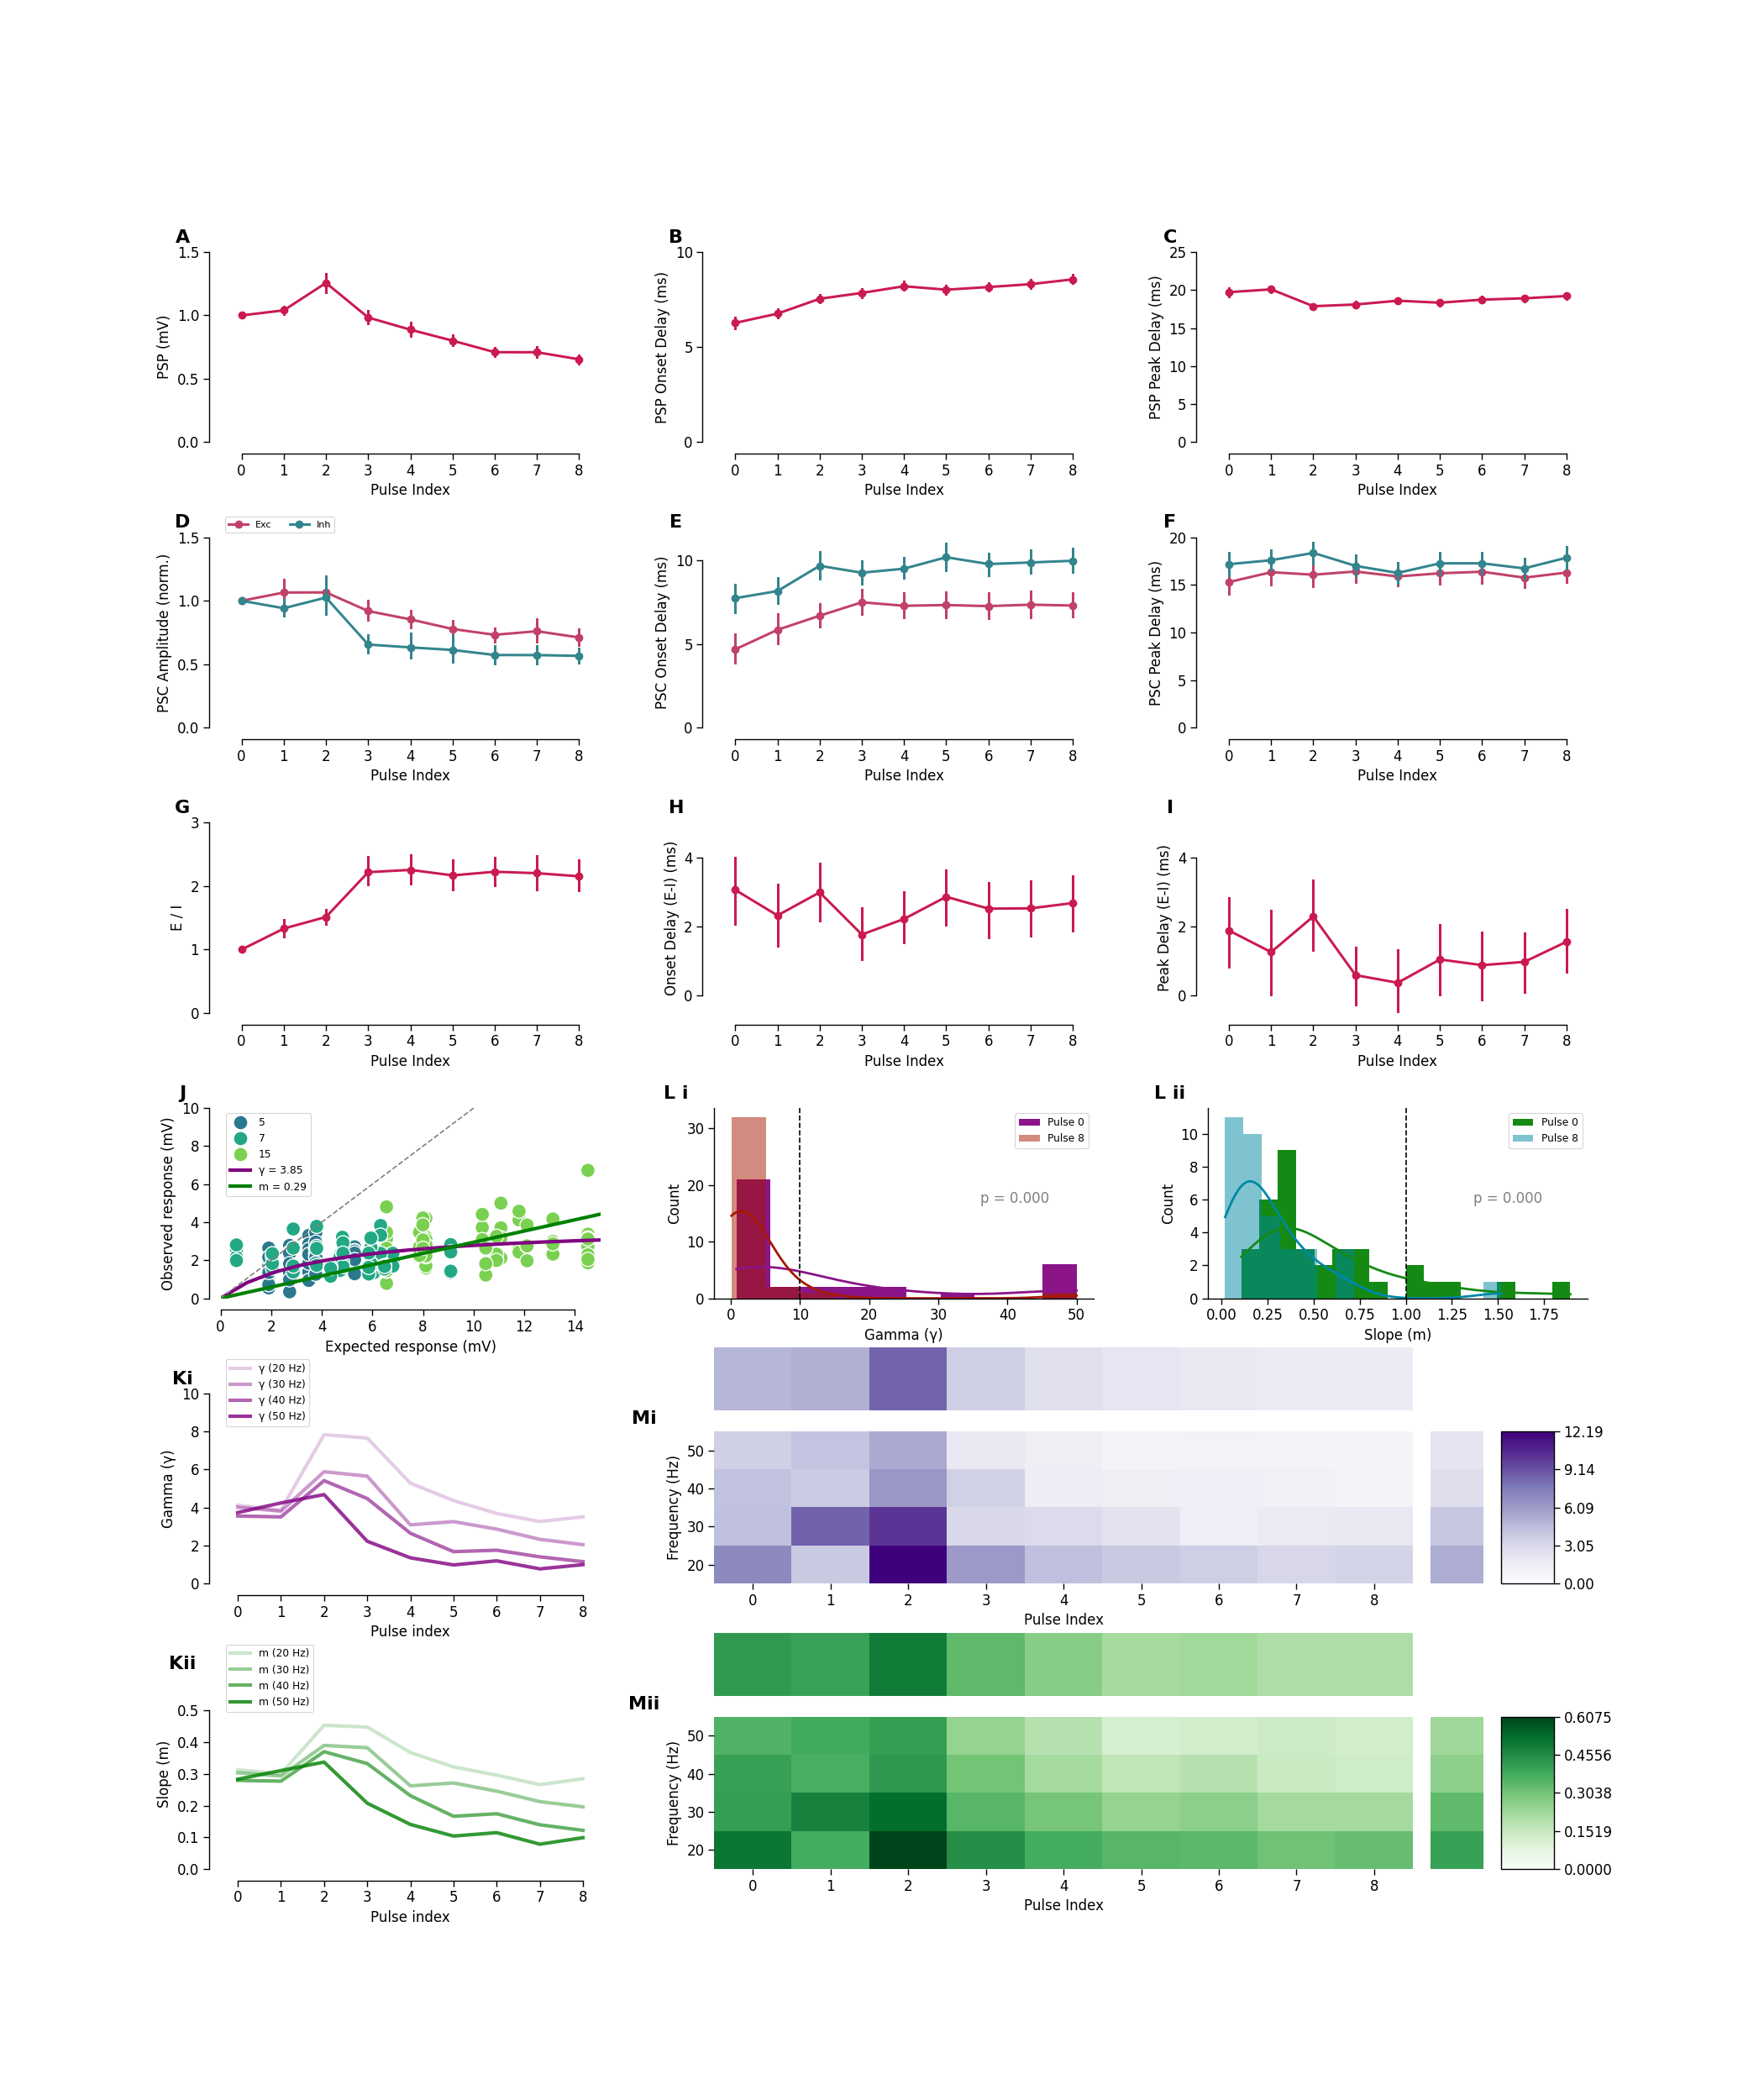

In [6]:
plt.close('all')

Fig3, ax3 = plt.subplot_mosaic([['A','B','C'],['D','E','F'],['G','H','I'],['J','Li','Lii'],['Ki','Mi','Mi'],['Kii','Mii','Mii']], figsize=(21,25),)
plt.subplots_adjust(wspace=0.3, hspace=0.5)

color_pulses_lin   = mpl.colormaps['Greens']
color_pulses_gamma = mpl.colormaps['Purples']

# drop all rows where gamma is nan
fitdf_slice = fitdf[~fitdf['gamma'].isna()]
selected_cell = 3402

# ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# ############ Voltage clamp plots #################
# E by I ratio vs pulse index across frequencies
ax3['A'].text(-0.1, 1.05, 'A', fontweight='bold', fontsize=16, ha='center', transform=ax3['A'].transAxes)
sns.pointplot(data=cc_delay_df, x='pulse', y='peak_PSP', ax=ax3['A'], color=rocket_r(0.5), errorbar='ci',)
# run a kruskal wallis test across the pulsewise responses
pulsewise_responses = cc_delay_df.pivot_table(columns='pulse', index='trialID', values='peak_PSP', )
# now run KW test across columns
kw_res = kruskal(*[pulsewise_responses[col] for col in pulsewise_responses.columns])
ax3['A'].set_ylim([0, 1.5])
ax3['A'].set_yticks([0,0.5,1.0,1.5])
ax3['A'].legend([],[], frameon=False)
ax3['A'].set_ylabel('PSP (mV)', fontsize=12)
ax3['A'].set_xlabel('Pulse Index', fontsize=12)
sns.despine(ax=ax3['A'], top=True, right=True, offset=10, trim=True)

ax3['D'].text(-0.1, 1.05, 'D', fontweight='bold', fontsize=16, ha='center', transform=ax3['D'].transAxes)
sns.pointplot(data=ebyi_df, x='pulse', y=-70, ax=ax3['D'], color=flare(0.5), errorbar='ci', label='Exc')
sns.pointplot(data=ebyi_df, x='pulse', y = 0, ax=ax3['D'], color=crest(0.5), errorbar='ci', label='Inh' )
ax3['D'].set_ylim([0,1.5])
ax3['D'].set_yticks([0,0.5,1.0,1.5])
ax3['D'].legend(loc='lower left', ncols=4, fontsize='small', bbox_to_anchor=(0.0, 1.0))
ax3['D'].set_ylabel('PSC Amplitude (norm.)', fontsize=12)
ax3['D'].set_xlabel('Pulse Index', fontsize=12)
sns.despine(ax=ax3['D'], top=True, right=True, offset=10, trim=True)

ax3['G'].text(-0.1, 1.05, 'G', fontweight='bold', fontsize=16, ha='center', transform=ax3['G'].transAxes)
sns.pointplot(data=ebyi_df, x='pulse', y='EbyI', ax=ax3['G'], color=rocket_r(0.5), errorbar='ci',)
ax3['G'].set_ylim([0, 3])
ax3['G'].set_yticks(np.arange(0,3.1,1))
ax3['G'].legend([],[], frameon=False)
ax3['G'].set_ylabel('E / I', fontsize=12)
ax3['G'].set_xlabel('Pulse Index', fontsize=12)
sns.despine(ax=ax3['G'], top=True, right=True, offset=10, trim=True)

### ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

ax3['B'].text(-0.1, 1.05, 'B', fontweight='bold', fontsize=16, ha='center', transform=ax3['B'].transAxes)
sns.pointplot(data=cc_delay_df, x='pulse', y='onset_delay', ax=ax3['B'], color=rocket_r(0.5), errorbar='ci',)
ax3['B'].set_ylim([0, 10])
ax3['B'].set_yticks([0,5,10])
# ax3['B'].legend(loc='upper left', ncols=4, fontsize='small', bbox_to_anchor=(0.0, 1.0))
ax3['B'].set_ylabel('PSP Onset Delay (ms)', fontsize=12)
ax3['B'].set_xlabel('Pulse Index', fontsize=12)
sns.despine(ax=ax3['B'], top=True, right=True, offset=10, trim=True)

ax3['E'].text(-0.1, 1.05, 'E', fontweight='bold', fontsize=16, ha='center', transform=ax3['E'].transAxes)
sns.pointplot(data=vc_delay_df, x='pulse', y='exc_onset', ax=ax3['E'], color=flare(0.5), errorbar='ci',)
sns.pointplot(data=vc_delay_df, x='pulse', y='inh_onset', ax=ax3['E'], color=crest(0.5), errorbar='ci',)
ax3['E'].set_xticks( np.arange(0,9))
ax3['E'].set_yticks( np.arange(0,11,5))
ax3['E'].set_xlabel('Pulse Index', fontsize=12)
ax3['E'].set_ylabel('PSC Onset Delay (ms)')
ax3['E'].legend([],[], frameon=False)
# ax3['E'].legend( loc='lower left', ncols=4, fontsize='small', bbox_to_anchor=(0.0, 0.0))
[ax3['E'].spines[place].set_visible(False) for place in ['top', 'right', ] ]
sns.despine(ax=ax3['E'], offset=10, trim=True)

ax3['H'].text(-0.1, 1.05, 'H', fontweight='bold', fontsize=16, ha='center', transform=ax3['H'].transAxes)
sns.pointplot(data=vc_delay_df, x='pulse', y='onset_delayEI', ax=ax3['H'], color=rocket_r(0.5), errorbar='ci',)
ax3['H'].set_ylim([-0.5,5])
ax3['H'].set_yticks([0,2,4])
ax3['H'].legend([],[], frameon=False)
ax3['H'].set_ylabel('Onset Delay (E-I) (ms)', fontsize=12)
ax3['H'].set_xlabel('Pulse Index', fontsize=12)
sns.despine(ax=ax3['H'], top=True, right=True, offset=10, trim=True)


# ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Voltage clamp plots
# onset delay vs pulse index across frequencies
# E by I ratio vs pulse index across frequencies
ax3['C'].text(-0.1, 1.05, 'C', fontweight='bold', fontsize=16, ha='center', transform=ax3['C'].transAxes)
sns.pointplot(data=cc_delay_df, x='pulse', y='peak_delay', ax=ax3['C'], color=rocket_r(0.5), errorbar='ci',)
ax3['C'].set_ylim([0, 25])
ax3['C'].set_yticks(np.arange(0,26,5))
ax3['C'].legend([],[], frameon=False)
ax3['C'].set_ylabel('PSP Peak Delay (ms)', fontsize=12)
ax3['C'].set_xlabel('Pulse Index', fontsize=12)
sns.despine(ax=ax3['C'], top=True, right=True, offset=10, trim=True)

sns.pointplot(data=vc_delay_df, x='pulse', y='exc_peak', ax=ax3['F'], color=flare(0.5), errorbar='ci',)
sns.pointplot(data=vc_delay_df, x='pulse', y='inh_peak', ax=ax3['F'], color=crest(0.5), errorbar='ci',)

ax3['F'].text(-0.1, 1.05, 'F', fontweight='bold', fontsize=16, ha='center', transform=ax3['F'].transAxes)
# ax3['F'].set_ylim([0, 20])
ax3['F'].set_xticks( np.arange(0,9))
ax3['F'].set_yticks( np.arange(0,21,5))
ax3['F'].set_xlabel('Pulse Index', fontsize=12)
ax3['F'].set_ylabel('PSC Peak Delay (ms)')
ax3['F'].legend([],[], frameon=False)
[ax3['F'].spines[place].set_visible(False) for place in ['top', 'right', ] ]
sns.despine(ax=ax3['F'], offset=10, trim=True)

ax3['I'].text(-0.1, 1.05, 'I', fontweight='bold', fontsize=16, ha='center', transform=ax3['I'].transAxes)
sns.pointplot(data=vc_delay_df, x='pulse', y='peak_delayEI', ax=ax3['I'], color=rocket_r(0.5), errorbar='ci',)
ax3['I'].set_ylim([-0.5,5])
ax3['I'].set_yticks(np.arange(0,6,2))
ax3['I'].set_ylabel('Peak Delay (E-I) (ms)', fontsize=12)
ax3['I'].set_xlabel('Pulse Index', fontsize=12)
ax3['I'].legend([],[], frameon=False)
sns.despine(ax=ax3['I'], top=True, right=True, offset=10, trim=True)

### ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Plot 3A: Scatterplot and SDN for cell = selected_cell, pulse = 0
ax3['J'].text(-0.1, 1.05, 'J', fontweight='bold', fontsize=16, ha='center', transform=ax3['J'].transAxes)
dftemp = sdn_df[(sdn_df['cellID']==selected_cell) & (sdn_df['pulse']==0) & (sdn_df['AP']==0)]
ax3['J'] = sns.scatterplot(data=dftemp, x='exp', y='obs', hue='numSq', size='numSq',sizes=[150], ax=ax3['J'], palette=color_squares)
# add gamma fit for 0th pule and all frequencies
gammatemp       = fitdf_slice[(fitdf_slice['cellID']==selected_cell)&(fitdf_slice['observed']=='obs')&(fitdf_slice['pulse']==0)&(fitdf_slice['stimFreq']==1000)]['gamma'].values
slopetemp       = fitdf_slice[(fitdf_slice['cellID']==selected_cell)&(fitdf_slice['observed']=='obs')&(fitdf_slice['pulse']==0)&(fitdf_slice['stimFreq']==1000)]['slope'].values
r2_gammatemp    = fitdf_slice[(fitdf_slice['cellID']==selected_cell)&(fitdf_slice['observed']=='obs')&(fitdf_slice['pulse']==0)&(fitdf_slice['stimFreq']==1000)]['r2_sdn'].values
r2_slopetemp    = fitdf_slice[(fitdf_slice['cellID']==selected_cell)&(fitdf_slice['observed']=='obs')&(fitdf_slice['pulse']==0)&(fitdf_slice['stimFreq']==1000)]['r2_lin'].values
print(gammatemp, slopetemp, r2_gammatemp, r2_slopetemp)
ax3['J'].plot(np.linspace(0,20,20), sdnfunc(np.linspace(0,20,20),gammatemp), color='purple', linewidth=3, label=f'γ = {gammatemp[0]:.2f}')
ax3['J'].plot(np.linspace(0,20,20), nosdn(np.linspace(0,20,20),slopetemp),   color='green', linewidth=3,    label=f'm = {slopetemp[0]:.2f}')
ax3['J'].plot([0,15],[0,15], color='grey', linestyle='--')

ax3['J'].set_xlabel('Expected response (mV)')
ax3['J'].set_ylabel('Observed response (mV)')
ax3['J'].legend(loc='upper left')

ax3['J'].set_xlim([0,15])
ax3['J'].set_ylim([0,10])
sns.despine(bottom=False, left=False, trim=True, offset=10, ax=ax3['J'])

# ### ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# # Plot 3B: lineplot of gamma across all cells, where x-axis: pulse, y-axis: gamma, hue: stim_freq
ax3['Ki' ].text(-0.1, 1.05, 'Ki',  fontweight='bold', fontsize=16, ha='center', transform=ax3['Ki'].transAxes)
ax3['Kii'].text(-0.1, 1.05, 'Kii', fontweight='bold', fontsize=16, ha='center', transform=ax3['Kii'].transAxes)


for i,f in enumerate([20,30,40,50]):
    gammas = []
    slopes = []
    for p in range(9):
        dftemp = sdn_df[(sdn_df['cellID']==selected_cell) & (sdn_df['pulse']==p)& (sdn_df['stimFreq']==f)]
        if dftemp.shape[0] == 0:
            continue
        gammatemp = fitdf_slice[(fitdf_slice['cellID']==selected_cell)&(fitdf_slice['observed']=='obs')&(fitdf_slice['pulse']==p)&(fitdf_slice['stimFreq']==f)]['gamma'].values
        slopetemp = fitdf_slice[(fitdf_slice['cellID']==selected_cell)&(fitdf_slice['observed']=='obs')&(fitdf_slice['pulse']==p)&(fitdf_slice['stimFreq']==f)]['slope'].values
        gammas.append(gammatemp)
        slopes.append(slopetemp)

    ax3['Ki' ].plot(np.arange(9), np.array(gammas), color='purple', linewidth=3, label=f'γ ({f} Hz)', alpha=0.2+i*0.2)
    ax3['Kii'].plot(np.arange(9), np.array(slopes), color='green', linewidth=3, label=f'm ({f} Hz)', alpha=0.2+i*0.2)

    # set ylim
    ax3['Ki'].set_ylim( [0, 10])
    ax3['Kii'].set_ylim([0,0.6])

    sns.despine(bottom=False, left=False, ax=ax3['Ki'],  trim=True, offset=10)
    sns.despine(bottom=False, left=False, ax=ax3['Kii'], trim=True, offset=10)

    # legend outside
    ax3['Ki'].legend( bbox_to_anchor=(0.0, 0.8),  loc='lower left')
    ax3['Kii'].legend(bbox_to_anchor=(0.0, 0.8), loc='lower left')

    ax3['Ki'].set_xlabel('Pulse index', fontdict={'fontsize':12})
    ax3['Ki'].set_ylabel('Gamma (γ)', fontdict={'fontsize':12})
    ax3['Kii'].set_xlabel('Pulse index', fontdict={'fontsize':12})
    ax3['Kii'].set_ylabel('Slope (m)', fontdict={'fontsize':12})


### ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Histogram of gamma values for all the cells in the control condition
ax3['Li'].text( -0.1, 1.05, 'L i', fontweight='bold', fontsize=16, ha='center', transform=ax3['Li'].transAxes)
ax3['Lii'].text(-0.1, 1.05, 'L ii', fontweight='bold', fontsize=16, ha='center', transform=ax3['Lii'].transAxes)

gammadist0 = fitdf[(fitdf['cellID']!=1000) &(fitdf['pulse']==0) & (fitdf['stimFreq']!=1000)& (fitdf['observed']=='obs')& (fitdf['sample_size']!=0)].dropna(subset=['gamma','slope'])
gammadist8 = fitdf[(fitdf['cellID']!=1000) &(fitdf['pulse']==8) & (fitdf['stimFreq']!=1000)& (fitdf['observed']=='obs')& (fitdf['sample_size']!=0)].dropna(subset=['gamma','slope'])
# any gamma value above 100 can be capped at 100
cap = 50
gammadist0['gamma'] = gammadist0['gamma'].apply(lambda x: cap if x>cap else x)
gammadist8['gamma'] = gammadist8['gamma'].apply(lambda x: cap if x>cap else x)

sns.histplot(data=gammadist0, x='gamma', color='#8b1489', kde=True, ax=ax3['Li'], alpha=1.0, edgecolor='None', binwidth=5, label='Pulse 0', line_kws={'lw': 2,})
sns.histplot(data=gammadist8, x='gamma', color='#a61900', kde=True, ax=ax3['Li'], alpha=0.5, edgecolor='None', binwidth=5, label='Pulse 8', line_kws={'lw': 2,})

sns.histplot(data=gammadist0, x='slope', color='#148a14', kde=True, ax=ax3['Lii'], alpha=1.0, edgecolor='None', binwidth=0.1, label='Pulse 0', line_kws={'lw': 2,})
sns.histplot(data=gammadist8, x='slope', color='#0088a5', kde=True, ax=ax3['Lii'], alpha=0.5, edgecolor='None', binwidth=0.1, label='Pulse 8', line_kws={'lw': 2,})

# add a vertical line at gammma = 10 and slope = 1
ax3['Li'].axvline(10, color='black', linestyle='--')
ax3['Lii'].axvline(1, color='black', linestyle='--')

ax3['Li'].set_xlabel('Gamma (γ)', fontsize=12)
ax3['Li'].set_ylabel('Count', fontsize=12)
ax3['Lii'].set_xlabel('Slope (m)', fontsize=12)
ax3['Lii'].set_ylabel('Count', fontsize=12)

sns.despine(bottom=False, left=False, ax=ax3['Li'])
sns.despine(bottom=False, left=False, ax=ax3['Lii'])
ax3['Li'].tick_params(axis='both', which='major', labelsize=12)
ax3['Lii'].tick_params(axis='both', which='major', labelsize=12)

ax3['Li'].legend(loc='upper right')
ax3['Lii'].legend(loc='upper right')

# statistics on gamma and slope
# rank-order test to check if pulse 0 and pulse 8 distributions are different
_, pval_gamma = mannwhitneyu(gammadist0['slope'], gammadist8['slope'])
_, pval_slope = mannwhitneyu(gammadist0['slope'], gammadist8['slope'])

# stat annotate on the plot
ax3['Li'].text(0.7, 0.5, f'p = {pval_gamma:.3f}', transform=ax3['Li'].transAxes, fontsize=12, color='grey')
ax3['Lii'].text(0.7, 0.5, f'p = {pval_slope:.3f}', transform=ax3['Lii'].transAxes, fontsize=12, color='grey')

# ### ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Plot 3D: Heatmap of slope
importlib.reload(plot_tools)

fitdf_slice = fitdf[(fitdf['cellID']!=1000) & (fitdf['pulse']!=1000) & (fitdf['stimFreq']!=1000)& (fitdf['observed']=='obs')& (fitdf['sample_size']!=0)].dropna(subset=['gamma','slope'])

fitdf_slice.drop(columns=['expected','observed','cellID'], inplace=True)
x = fitdf_slice.groupby(['pulse', 'stimFreq']).median().reset_index()
n = fitdf_slice.groupby(['pulse', 'stimFreq']).count().reset_index()
gammapivot = x.pivot(index='stimFreq', columns='pulse', values='gamma')
gammapivot_n = n.pivot(index='stimFreq', columns='pulse', values='gamma')
slopepivot = x.pivot(index='stimFreq', columns='pulse', values='slope')
slopepivot_n = n.pivot(index='stimFreq', columns='pulse', values='slope')
ax3['Mi'], _, _, _, _ = plot_tools.ax_to_partial_dist_heatmap_ax(gammapivot, gammapivot_n, Fig3, ax3['Mi'], barw=0.03, pad=0.01, shrink=0.8, palette='Purples', force_vmin_to_zero=True, annotate=False)
ax3['Mii'], _, _, _, _ = plot_tools.ax_to_partial_dist_heatmap_ax(slopepivot, slopepivot_n, Fig3, ax3['Mii'], barw=0.03, pad=0.01, shrink=0.8, palette='Greens', force_vmin_to_zero=True, annotate=False)
ax3['Mi'].text( -0.1, 1.05, 'Mi', fontweight='bold', fontsize=16, ha='center', transform=ax3['Mi'].transAxes)
ax3['Mii'].text(-0.1, 1.05, 'Mii', fontweight='bold', fontsize=16, ha='center', transform=ax3['Mii'].transAxes)


# ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
for a in ax3.keys():
    ax3[a].tick_params(axis='both', which='major', labelsize=12)
    # axis label fontsize
    ax3[a].set_xlabel(ax3[a].get_xlabel(), fontsize=12)
    ax3[a].set_ylabel(ax3[a].get_ylabel(), fontsize=12)
    # spine width
    ax3[a].spines['left'].set_linewidth(1)
    ax3[a].spines['bottom'].set_linewidth(1)

# Fig3.tight_layout()
## save fig 3
Fig3.savefig(paper_figure_export_location / 'Figure3v6.png', dpi=300, bbox_inches='tight')
Fig3.savefig(paper_figure_export_location / 'Figure3v6.svg', dpi=300, bbox_inches='tight')

## Fig 3v5

C:\Users\Aditya\AppData\Local\Temp\ipykernel_16392\962230405.py:17: UserWarning: 
The sizes list has fewer values (1) than needed (3) and will cycle, which may produce an uninterpretable plot.
  ax3['J'] = sns.scatterplot(data=dftemp, x='exp', y='obs', hue='numSq', size='numSq',sizes=[150], ax=ax3['J'], palette=color_squares)


[3.85347148] [0.29472188] [0.00913653] [-0.76242031]


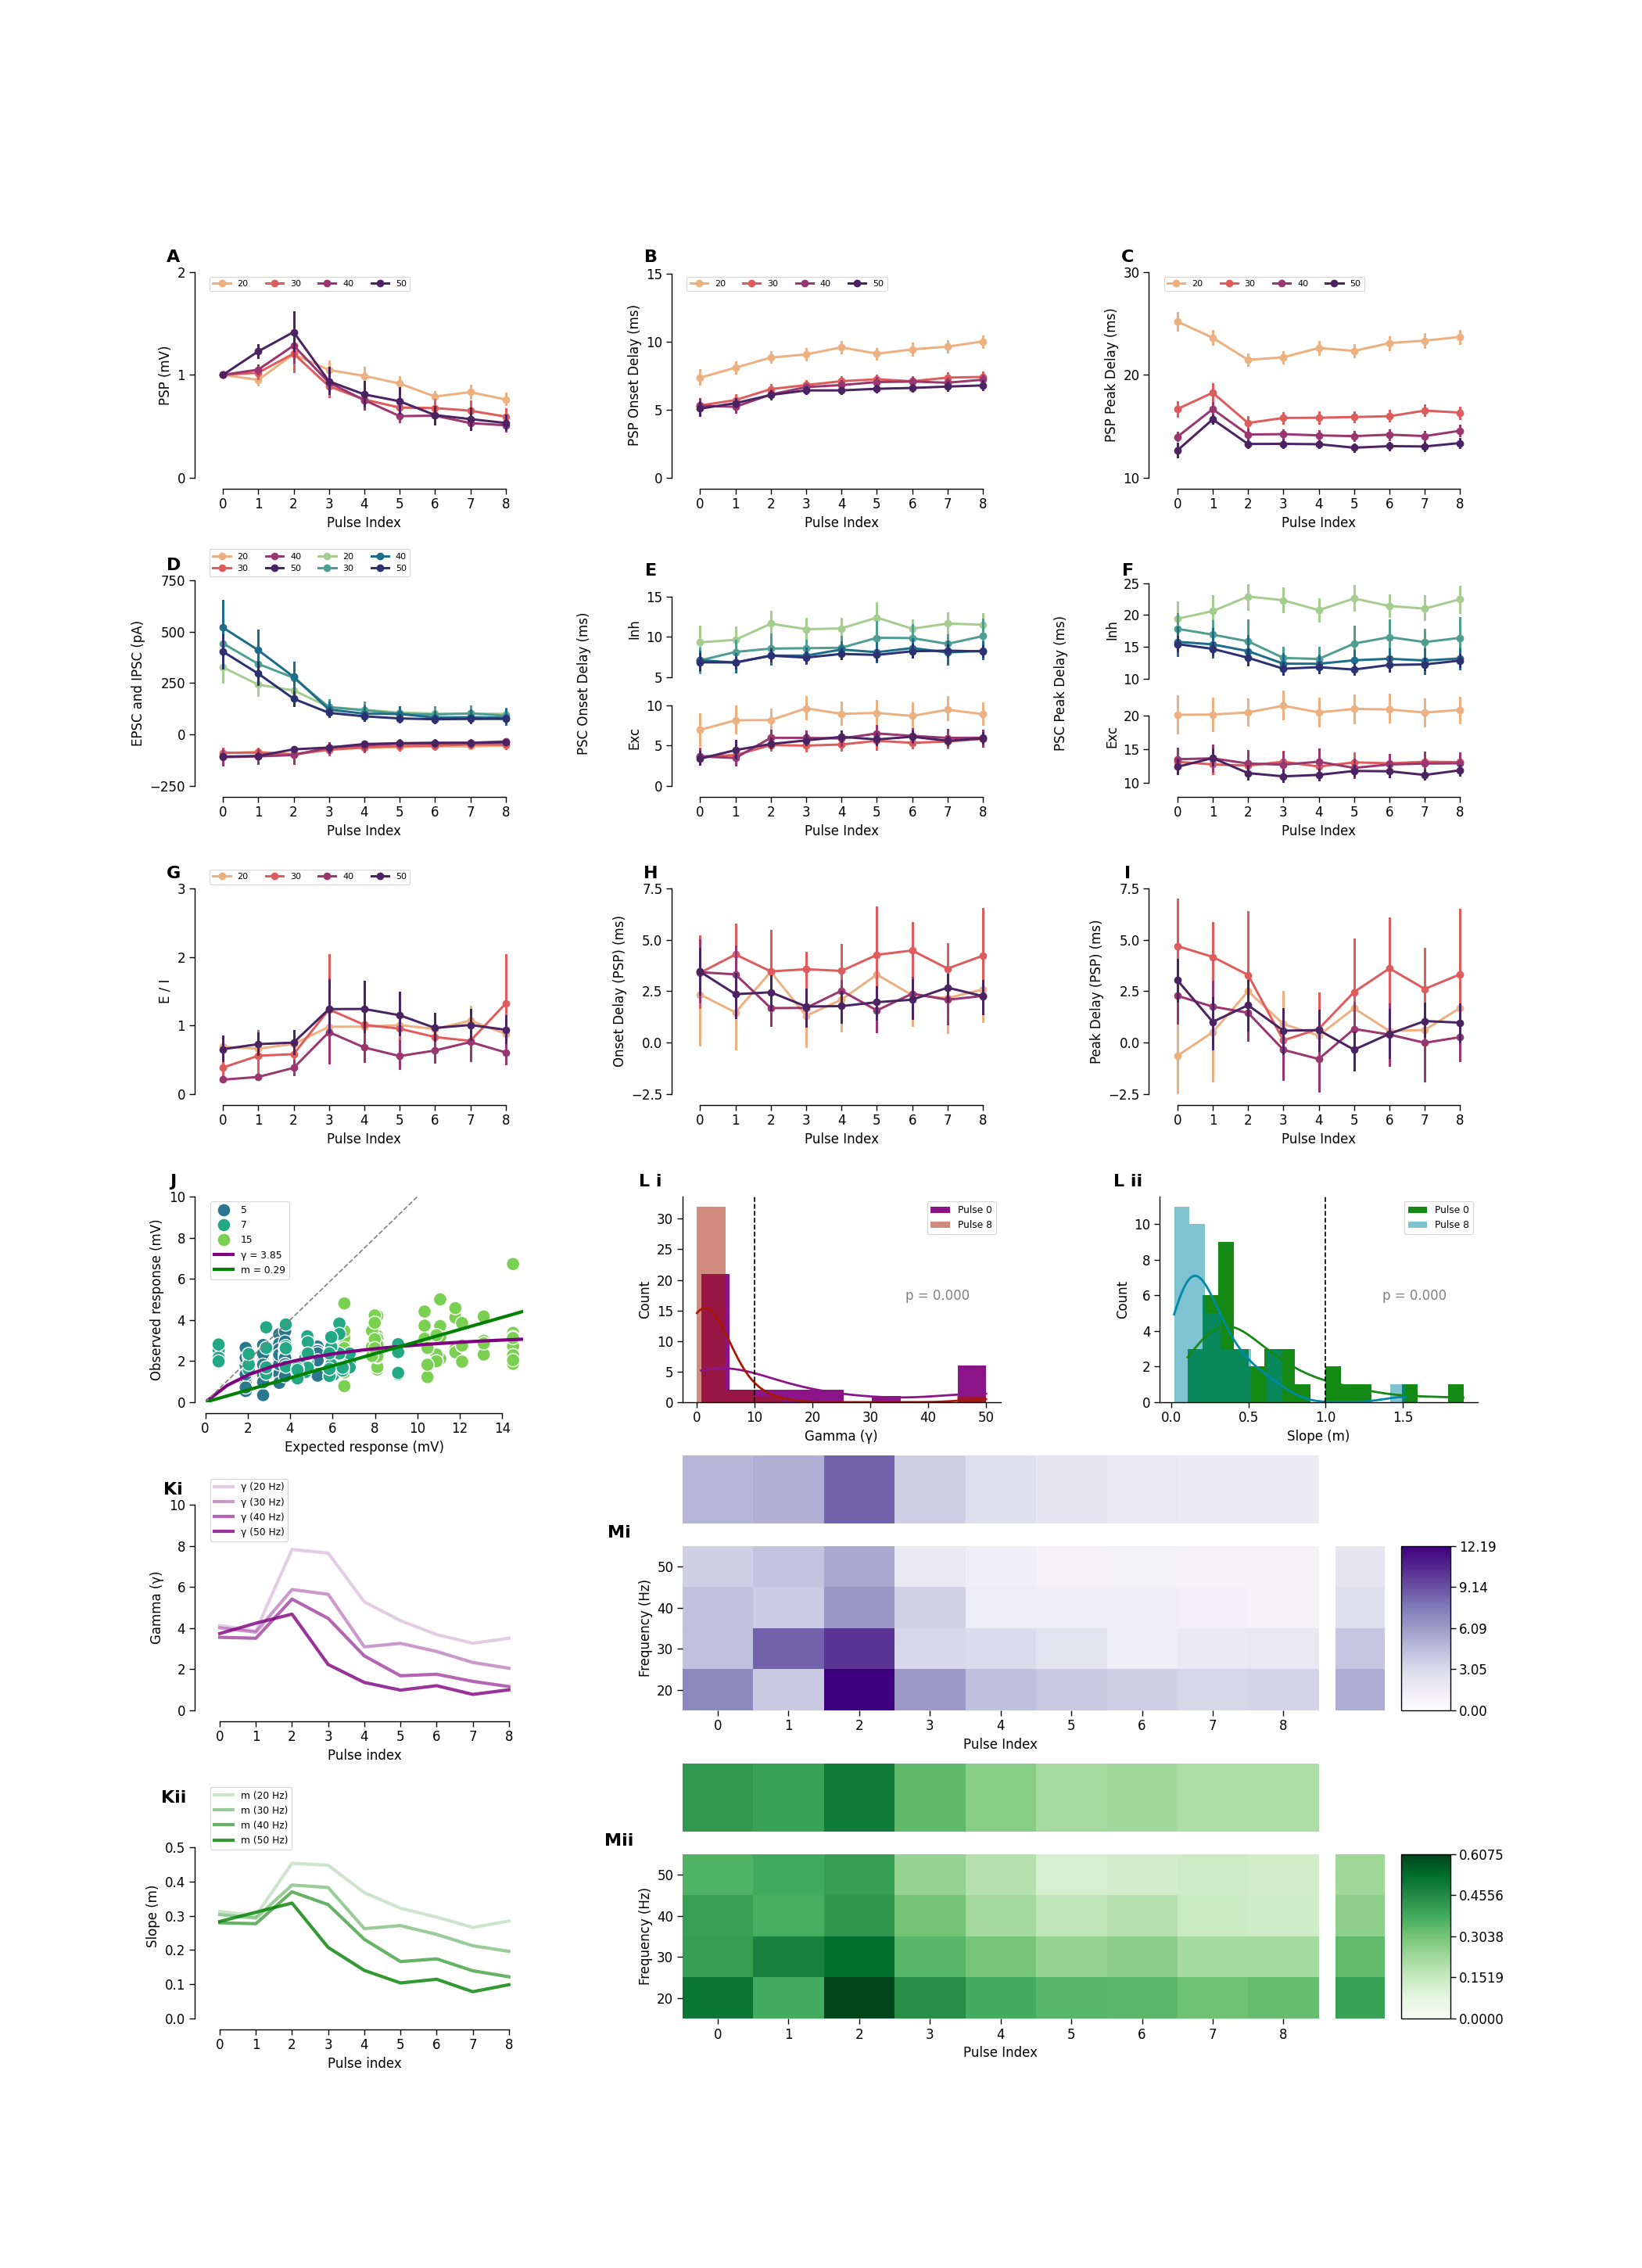

In [ ]:
plt.close('all')

Fig3, ax3 = plt.subplot_mosaic([['A','B','C'],['D','E','F'],['G','H','I'],['J','Li','Lii'],['Ki','Mi','Mi'],['Kii','Mii','Mii']], figsize=(21,29),)
plt.subplots_adjust(wspace=0.5, hspace=0.5)

color_pulses_lin   = mpl.colormaps['Greens']
color_pulses_gamma = mpl.colormaps['Purples']

# drop all rows where gamma is nan
fitdf_slice = fitdf[~fitdf['gamma'].isna()]
selected_cell = 3402

### ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Plot 3A: Scatterplot and SDN for cell = selected_cell, pulse = 0
ax3['J'].text(-0.1, 1.05, 'J', fontweight='bold', fontsize=16, ha='center', transform=ax3['J'].transAxes)
dftemp = sdn_df[(sdn_df['cellID']==selected_cell) & (sdn_df['pulse']==0) & (sdn_df['AP']==0)]
ax3['J'] = sns.scatterplot(data=dftemp, x='exp', y='obs', hue='numSq', size='numSq',sizes=[150], ax=ax3['J'], palette=color_squares)
# add gamma fit for 0th pule and all frequencies
gammatemp       = fitdf_slice[(fitdf_slice['cellID']==selected_cell)&(fitdf_slice['observed']=='obs')&(fitdf_slice['pulse']==0)&(fitdf_slice['stimFreq']==1000)]['gamma'].values
slopetemp       = fitdf_slice[(fitdf_slice['cellID']==selected_cell)&(fitdf_slice['observed']=='obs')&(fitdf_slice['pulse']==0)&(fitdf_slice['stimFreq']==1000)]['slope'].values
r2_gammatemp    = fitdf_slice[(fitdf_slice['cellID']==selected_cell)&(fitdf_slice['observed']=='obs')&(fitdf_slice['pulse']==0)&(fitdf_slice['stimFreq']==1000)]['r2_sdn'].values
r2_slopetemp    = fitdf_slice[(fitdf_slice['cellID']==selected_cell)&(fitdf_slice['observed']=='obs')&(fitdf_slice['pulse']==0)&(fitdf_slice['stimFreq']==1000)]['r2_lin'].values
print(gammatemp, slopetemp, r2_gammatemp, r2_slopetemp)
ax3['J'].plot(np.linspace(0,20,20), sdnfunc(np.linspace(0,20,20),gammatemp), color='purple', linewidth=3, label=f'γ = {gammatemp[0]:.2f}')
ax3['J'].plot(np.linspace(0,20,20), nosdn(np.linspace(0,20,20),slopetemp),   color='green', linewidth=3,    label=f'm = {slopetemp[0]:.2f}')
ax3['J'].plot([0,15],[0,15], color='grey', linestyle='--')

ax3['J'].set_xlabel('Expected response (mV)')
ax3['J'].set_ylabel('Observed response (mV)')
ax3['J'].legend(loc='upper left')

ax3['J'].set_xlim([0,15])
ax3['J'].set_ylim([0,10])
sns.despine(bottom=False, left=False, trim=True, offset=10, ax=ax3['J'])

# ### ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# # Plot 3B: lineplot of gamma across all cells, where x-axis: pulse, y-axis: gamma, hue: stim_freq
ax3['Ki' ].text(-0.1, 1.05, 'Ki',  fontweight='bold', fontsize=16, ha='center', transform=ax3['Ki'].transAxes)
ax3['Kii'].text(-0.1, 1.05, 'Kii', fontweight='bold', fontsize=16, ha='center', transform=ax3['Kii'].transAxes)


for i,f in enumerate([20,30,40,50]):
    gammas = []
    slopes = []
    for p in range(9):
        dftemp = sdn_df[(sdn_df['cellID']==selected_cell) & (sdn_df['pulse']==p)& (sdn_df['stimFreq']==f)]
        if dftemp.shape[0] == 0:
            continue
        gammatemp = fitdf_slice[(fitdf_slice['cellID']==selected_cell)&(fitdf_slice['observed']=='obs')&(fitdf_slice['pulse']==p)&(fitdf_slice['stimFreq']==f)]['gamma'].values
        slopetemp = fitdf_slice[(fitdf_slice['cellID']==selected_cell)&(fitdf_slice['observed']=='obs')&(fitdf_slice['pulse']==p)&(fitdf_slice['stimFreq']==f)]['slope'].values
        gammas.append(gammatemp)
        slopes.append(slopetemp)

    ax3['Ki' ].plot(np.arange(9), np.array(gammas), color='purple', linewidth=3, label=f'γ ({f} Hz)', alpha=0.2+i*0.2)
    ax3['Kii'].plot(np.arange(9), np.array(slopes), color='green', linewidth=3, label=f'm ({f} Hz)', alpha=0.2+i*0.2)

    # set ylim
    ax3['Ki'].set_ylim( [0, 10])
    ax3['Kii'].set_ylim([0,0.6])

    sns.despine(bottom=False, left=False, ax=ax3['Ki'],  trim=True, offset=10)
    sns.despine(bottom=False, left=False, ax=ax3['Kii'], trim=True, offset=10)

    # legend outside
    ax3['Ki'].legend( bbox_to_anchor=(0.0, 0.8),  loc='lower left')
    ax3['Kii'].legend(bbox_to_anchor=(0.0, 0.8), loc='lower left')

    ax3['Ki'].set_xlabel('Pulse index', fontdict={'fontsize':12})
    ax3['Ki'].set_ylabel('Gamma (γ)', fontdict={'fontsize':12})
    ax3['Kii'].set_xlabel('Pulse index', fontdict={'fontsize':12})
    ax3['Kii'].set_ylabel('Slope (m)', fontdict={'fontsize':12})


### ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Histogram of gamma values for all the cells in the control condition
ax3['Li'].text( -0.1, 1.05, 'L i', fontweight='bold', fontsize=16, ha='center', transform=ax3['Li'].transAxes)
ax3['Lii'].text(-0.1, 1.05, 'L ii', fontweight='bold', fontsize=16, ha='center', transform=ax3['Lii'].transAxes)

gammadist0 = fitdf[(fitdf['cellID']!=1000) &(fitdf['pulse']==0) & (fitdf['stimFreq']!=1000)& (fitdf['observed']=='obs')& (fitdf['sample_size']!=0)].dropna(subset=['gamma','slope'])
gammadist8 = fitdf[(fitdf['cellID']!=1000) &(fitdf['pulse']==8) & (fitdf['stimFreq']!=1000)& (fitdf['observed']=='obs')& (fitdf['sample_size']!=0)].dropna(subset=['gamma','slope'])
# any gamma value above 100 can be capped at 100
cap = 50
gammadist0['gamma'] = gammadist0['gamma'].apply(lambda x: cap if x>cap else x)
gammadist8['gamma'] = gammadist8['gamma'].apply(lambda x: cap if x>cap else x)

sns.histplot(data=gammadist0, x='gamma', color='#8b1489', kde=True, ax=ax3['Li'], alpha=1.0, edgecolor='None', binwidth=5, label='Pulse 0', line_kws={'lw': 2,})
sns.histplot(data=gammadist8, x='gamma', color='#a61900', kde=True, ax=ax3['Li'], alpha=0.5, edgecolor='None', binwidth=5, label='Pulse 8', line_kws={'lw': 2,})

sns.histplot(data=gammadist0, x='slope', color='#148a14', kde=True, ax=ax3['Lii'], alpha=1.0, edgecolor='None', binwidth=0.1, label='Pulse 0', line_kws={'lw': 2,})
sns.histplot(data=gammadist8, x='slope', color='#0088a5', kde=True, ax=ax3['Lii'], alpha=0.5, edgecolor='None', binwidth=0.1, label='Pulse 8', line_kws={'lw': 2,})

# add a vertical line at gammma = 10 and slope = 1
ax3['Li'].axvline(10, color='black', linestyle='--')
ax3['Lii'].axvline(1, color='black', linestyle='--')

ax3['Li'].set_xlabel('Gamma (γ)', fontsize=12)
ax3['Li'].set_ylabel('Count', fontsize=12)
ax3['Lii'].set_xlabel('Slope (m)', fontsize=12)
ax3['Lii'].set_ylabel('Count', fontsize=12)

sns.despine(bottom=False, left=False, ax=ax3['Li'])
sns.despine(bottom=False, left=False, ax=ax3['Lii'])
ax3['Li'].tick_params(axis='both', which='major', labelsize=12)
ax3['Lii'].tick_params(axis='both', which='major', labelsize=12)

ax3['Li'].legend(loc='upper right')
ax3['Lii'].legend(loc='upper right')

# statistics on gamma and slope
# rank-order test to check if pulse 0 and pulse 8 distributions are different
_, pval_gamma = mannwhitneyu(gammadist0['slope'], gammadist8['slope'])
_, pval_slope = mannwhitneyu(gammadist0['slope'], gammadist8['slope'])

# stat annotate on the plot
ax3['Li'].text(0.7, 0.5, f'p = {pval_gamma:.3f}', transform=ax3['Li'].transAxes, fontsize=12, color='grey')
ax3['Lii'].text(0.7, 0.5, f'p = {pval_slope:.3f}', transform=ax3['Lii'].transAxes, fontsize=12, color='grey')

# ### ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Plot 3D: Heatmap of slope
importlib.reload(plot_tools)

fitdf_slice = fitdf[(fitdf['cellID']!=1000) & (fitdf['pulse']!=1000) & (fitdf['stimFreq']!=1000)& (fitdf['observed']=='obs')& (fitdf['sample_size']!=0)].dropna(subset=['gamma','slope'])

fitdf_slice.drop(columns=['expected','observed','cellID'], inplace=True)
x = fitdf_slice.groupby(['pulse', 'stimFreq']).median().reset_index()
n = fitdf_slice.groupby(['pulse', 'stimFreq']).count().reset_index()
gammapivot = x.pivot(index='stimFreq', columns='pulse', values='gamma')
gammapivot_n = n.pivot(index='stimFreq', columns='pulse', values='gamma')
slopepivot = x.pivot(index='stimFreq', columns='pulse', values='slope')
slopepivot_n = n.pivot(index='stimFreq', columns='pulse', values='slope')
ax3['Mi'], _, _, _, _ = plot_tools.ax_to_partial_dist_heatmap_ax(gammapivot, gammapivot_n, Fig3, ax3['Mi'], barw=0.03, pad=0.01, shrink=0.8, palette='Purples', force_vmin_to_zero=True, annotate=False)
ax3['Mii'], _, _, _, _ = plot_tools.ax_to_partial_dist_heatmap_ax(slopepivot, slopepivot_n, Fig3, ax3['Mii'], barw=0.03, pad=0.01, shrink=0.8, palette='Greens', force_vmin_to_zero=True, annotate=False)
ax3['Mi'].text( -0.1, 1.05, 'Mi', fontweight='bold', fontsize=16, ha='center', transform=ax3['Mi'].transAxes)
ax3['Mii'].text(-0.1, 1.05, 'Mii', fontweight='bold', fontsize=16, ha='center', transform=ax3['Mii'].transAxes)

# ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Voltage clamp plots
# E by I ratio vs pulse index across frequencies
ax3['A'].text(-0.1, 1.05, 'A', fontweight='bold', fontsize=16, ha='center', transform=ax3['A'].transAxes)
sns.pointplot(data=cc_delay_df, x='pulse', y='peak_PSP', hue='stimFreq', ax=ax3['A'], palette=flare, errorbar='ci',)
ax3['A'].set_ylim([0, 2])
ax3['A'].set_yticks([0,1,2])
ax3['A'].legend(loc='upper left', ncols=4, fontsize='small', bbox_to_anchor=(0.0, 1.0))
ax3['A'].set_ylabel('PSP (mV)', fontsize=12)
ax3['A'].set_xlabel('Pulse Index', fontsize=12)
sns.despine(ax=ax3['A'], top=True, right=True, offset=10, trim=True)

ax3['D'].text(-0.1, 1.05, 'D', fontweight='bold', fontsize=16, ha='center', transform=ax3['D'].transAxes)
sns.pointplot(data=ebyi_df, x='pulse', y=-70, hue='stimFreq', ax=ax3['D'], palette="flare", errorbar='ci',)
sns.pointplot(data=ebyi_df, x='pulse', y = 0, hue='stimFreq', ax=ax3['D'], palette="crest", errorbar='ci',)
ax3['D'].set_ylim([-250, 750])
ax3['D'].set_yticks(np.arange(-250,760,250))
ax3['D'].legend(loc='lower left', ncols=4, fontsize='small', bbox_to_anchor=(0.0, 1.0))
ax3['D'].set_ylabel('EPSC and IPSC (pA)', fontsize=12)
ax3['D'].set_xlabel('Pulse Index', fontsize=12)
sns.despine(ax=ax3['D'], top=True, right=True, offset=10, trim=True)

ax3['G'].text(-0.1, 1.05, 'G', fontweight='bold', fontsize=16, ha='center', transform=ax3['G'].transAxes)
sns.pointplot(data=ebyi_df, x='pulse', y='EbyI', hue='stimFreq', ax=ax3['G'], palette="flare", errorbar='ci',)
ax3['G'].set_ylim([0, 3])
ax3['G'].set_yticks(np.arange(0,3.1,1))
ax3['G'].legend(loc='lower left', ncols=4, fontsize='small', bbox_to_anchor=(0.0, 1.0))
ax3['G'].set_ylabel('E / I', fontsize=12)
ax3['G'].set_xlabel('Pulse Index', fontsize=12)
sns.despine(ax=ax3['G'], top=True, right=True, offset=10, trim=True)

### ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

ax3['B'].text(-0.1, 1.05, 'B', fontweight='bold', fontsize=16, ha='center', transform=ax3['B'].transAxes)
sns.pointplot(data=cc_delay_df, x='pulse', y='onset_delay', hue='stimFreq', ax=ax3['B'], palette=flare, errorbar='ci',)
ax3['B'].set_ylim([0, 15.1])
ax3['B'].set_yticks([0,5,10,15])
ax3['B'].legend(loc='upper left', ncols=4, fontsize='small', bbox_to_anchor=(0.0, 1.0))
ax3['B'].set_ylabel('PSP Onset Delay (ms)', fontsize=12)
ax3['B'].set_xlabel('Pulse Index', fontsize=12)
sns.despine(ax=ax3['B'], top=True, right=True, offset=10, trim=True)

ax3i_loc = ax3['E'].get_position()
ax3['E'].remove()
pad = 0.03
ax3['E1'] = Fig3.add_axes([ax3i_loc.x0, ax3i_loc.y0, ax3i_loc.width, (0.5-pad)*ax3i_loc.height])
ax3['E2'] = Fig3.add_axes([ax3i_loc.x0, ax3i_loc.y0+(0.5+pad)*ax3i_loc.height, ax3i_loc.width, (0.5-pad)*ax3i_loc.height])

sns.pointplot(data=vc_delay_df, x='pulse', y='exc_onset', hue='stimFreq', ax=ax3['E1'], palette="flare", errorbar='ci',)
sns.pointplot(data=vc_delay_df, x='pulse', y='inh_onset', hue='stimFreq', ax=ax3['E2'], palette="crest", errorbar='ci',)

lim = 12
ax3['E1'].set_ylim([0, lim])
ax3['E1'].set_xticks( np.arange(0,9))
ax3['E1'].set_yticks( np.arange(0,11,5))
ax3['E1'].set_xlabel('Pulse Index', fontsize=12)
ax3['E1'].set_ylabel('Exc')
ax3['E1'].legend([],[], frameon=False)
# ax3['E1'].legend( loc='lower left', ncols=4, fontsize='small', bbox_to_anchor=(0.0, 0.0))
[ax3['E1'].spines[place].set_visible(False) for place in ['top', 'right', ] ]
sns.despine(ax=ax3['E1'], offset=10, trim=True)

ax3['E2'].text(-0.1, 1.05, 'E', fontweight='bold', fontsize=16, ha='center', transform=ax3['E2'].transAxes)
ax3['E2'].set_ylim([5, 5+lim])
ax3['E2'].set_xticks([])
ax3['E2'].set_yticks(np.arange(5,16,5))
ax3['E2'].set_ylabel('Inh')
ax3['E2'].legend([],[], frameon=False)
ax3['E2'].set_xlabel('')
# ax3['E2'].legend( loc='upper left', ncols=4, fontsize='small', bbox_to_anchor=(0.0, 1.0))
[ax3['E2'].spines[place].set_visible(False) for place in ['top', 'right', 'bottom'] ]
sns.despine(ax=ax3['E2'], bottom=True, offset=10, trim=True)

# get the position of ax3['E'] ylabel
label_locx = ax3['E'].get_position().x0 - 0.06
label_locy = ax3['E'].get_position().y0 + 0.5 * ax3['E'].get_position().height
Fig3.text(label_locx, label_locy, 'PSC Onset Delay (ms)', fontsize=12, ha='center', va='center', rotation='vertical')

ax3['H'].text(-0.1, 1.05, 'H', fontweight='bold', fontsize=16, ha='center', transform=ax3['H'].transAxes)
sns.pointplot(data=vc_delay_df, x='pulse', y='onset_delayEI', hue='stimFreq', ax=ax3['H'], palette="flare", errorbar='ci',)
ax3['H'].set_ylim([-2.5, 7.5])
ax3['H'].set_yticks(np.arange(-2.5,7.6,2.5))
ax3['H'].legend([],[], frameon=False)
ax3['H'].set_ylabel('Onset Delay (PSP) (ms)', fontsize=12)
ax3['H'].set_xlabel('Pulse Index', fontsize=12)
sns.despine(ax=ax3['H'], top=True, right=True, offset=10, trim=True)


# ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Voltage clamp plots
# onset delay vs pulse index across frequencies
# E by I ratio vs pulse index across frequencies
ax3['C'].text(-0.1, 1.05, 'C', fontweight='bold', fontsize=16, ha='center', transform=ax3['C'].transAxes)
sns.pointplot(data=cc_delay_df, x='pulse', y='peak_delay', hue='stimFreq', ax=ax3['C'], palette="flare", errorbar='ci',)
ax3['C'].set_ylim([10, 30])
ax3['C'].set_yticks(np.arange(10,31,10))
ax3['C'].legend(loc='upper left', ncols=4, fontsize='small', bbox_to_anchor=(0.0, 1.0))
ax3['C'].set_ylabel('PSP Peak Delay (ms)', fontsize=12)
ax3['C'].set_xlabel('Pulse Index', fontsize=12)
sns.despine(ax=ax3['C'], top=True, right=True, offset=10, trim=True)

ax3i_loc = ax3['F'].get_position()
ax3['F'].remove()
ax3['F1'] = Fig3.add_axes([ax3i_loc.x0, ax3i_loc.y0, ax3i_loc.width, 0.48*ax3i_loc.height])
ax3['F2'] = Fig3.add_axes([ax3i_loc.x0, ax3i_loc.y0+0.52*ax3i_loc.height, ax3i_loc.width, 0.48*ax3i_loc.height])

sns.pointplot(data=vc_delay_df, x='pulse', y='exc_peak', hue='stimFreq', ax=ax3['F1'], palette="flare", errorbar='ci',)
sns.pointplot(data=vc_delay_df, x='pulse', y='inh_peak', hue='stimFreq', ax=ax3['F2'], palette="crest", errorbar='ci',)

# ax3['F1'].set_ylim([0, lim])
ax3['F1'].set_xticks( np.arange(0,9))
# ax3['F1'].set_yticks( np.arange(0,11,5))
ax3['F1'].set_xlabel('Pulse Index', fontsize=12)
ax3['F1'].set_ylabel('Exc')
ax3['F1'].legend([],[], frameon=False)
# ax3['F1'].legend( loc='lower left', ncols=4, fontsize='small', bbox_to_anchor=(0.0, 0.0))
[ax3['F1'].spines[place].set_visible(False) for place in ['top', 'right', ] ]
sns.despine(ax=ax3['F1'], offset=10, trim=True)

ax3['F2'].text(-0.1, 1.05, 'F', fontweight='bold', fontsize=16, ha='center', transform=ax3['F2'].transAxes)
# ax3['F2'].set_ylim([5,5+lim])
# ax3['F2'].set_yticks(np.arange(5,16,5))
ax3['F2'].set_xticks([])
ax3['F2'].set_ylabel('Inh')
ax3['F2'].legend([],[], frameon=False)
# remove xlabel
ax3['F2'].set_xlabel('')
# ax3['F2'].legend( loc='upper left', ncols=4, fontsize='small', bbox_to_anchor=(0.0, 1.0))
[ax3['F2'].spines[place].set_visible(False) for place in ['top', 'right', 'bottom'] ]
sns.despine(ax=ax3['F2'], bottom=True, offset=10, trim=True)

# get the position of ax3['F'] ylabel
label_locx = ax3['F'].get_position().x0 - 0.06
label_locy = ax3['F'].get_position().y0 + 0.5 * ax3['J'].get_position().height
Fig3.text(label_locx, label_locy, 'PSC Peak Delay (ms)', fontsize=12, ha='center', va='center', rotation='vertical')

ax3['I'].text(-0.1, 1.05, 'I', fontweight='bold', fontsize=16, ha='center', transform=ax3['I'].transAxes)
sns.pointplot(data=vc_delay_df, x='pulse', y='peak_delayEI', hue='stimFreq', ax=ax3['I'], palette="flare", errorbar='ci',)
ax3['I'].set_ylim([-2.5,7.5])
ax3['I'].set_yticks(np.arange(-2.5,7.6,2.5))
ax3['I'].set_ylabel('Peak Delay (PSP) (ms)', fontsize=12)
ax3['I'].set_xlabel('Pulse Index', fontsize=12)
ax3['I'].legend([],[], frameon=False)
sns.despine(ax=ax3['I'], top=True, right=True, offset=10, trim=True)

# ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
for a in ['J','Ki','Kii','Li','Lii','Mi','Mii','A','B','C','D','E1','E2','F1','F2','G','H','I']:
    ax3[a].tick_params(axis='both', which='major', labelsize=12)
    # axis label fontsize
    ax3[a].set_xlabel(ax3[a].get_xlabel(), fontsize=12)
    ax3[a].set_ylabel(ax3[a].get_ylabel(), fontsize=12)



## save fig 3
# Fig3.savefig(paper_figure_export_location / 'Figure3v5.png', dpi=300, bbox_inches='tight')
# Fig3.savefig(paper_figure_export_location / 'Figure3v5.svg', dpi=300, bbox_inches='tight')

## Stat on pointplots

In [ ]:
pulsewise_responses = cc_delay_df.pivot_table(columns='pulse', index='trialID', values='peak_delay', )
kw_results = kruskal(*[pulsewise_responses[pulsewise_responses[col].notnull()][col].values for col in pulsewise_responses.columns])
print('group stat results:', np.round(kw_results[1], 3))
# run pulse vs pulse mann-whitney u test
# plt.figure()
print('all other pulse to pulse comparisons non-significant except the following:')
for i in range(9):
    for j in range(i+1, 9):
        a = pulsewise_responses[pulsewise_responses[i].notnull()][i].values
        b = pulsewise_responses[pulsewise_responses[j].notnull()][j].values
        mw, pval = mannwhitneyu(a,b)
        if pval > 0.05:
            print(i,j, np.round(pval,3))

group stat results: 0.0
all other pulse to pulse comparisons non-significant except the following:
0 4 0.057
0 6 0.286
0 7 0.439
0 8 0.963
3 4 0.361
3 5 0.417
3 6 0.052
4 5 0.877
4 6 0.338
4 7 0.123
5 6 0.25
5 7 0.078
6 7 0.542
6 8 0.092
7 8 0.296


In [ ]:
prop = 'peak_PSP'
start = 1
for i in range(start,9):
    # for each pulse index, compare across frequencies
    pulsewise_freq_responses = cc_delay_df[cc_delay_df['pulse']==i].pivot_table(columns='stimFreq', index='trialID', values=prop, )
    kw_results = kruskal(*[pulsewise_freq_responses[pulsewise_freq_responses[col].notnull()][col].values for col in pulsewise_freq_responses.columns])
    print(i, f'group stat results for pulse {i}, the chance that at least one sample is significant:', np.round(kw_results[1], 3))

    # now compare against each other
    print('all other freq to freq comparisons non-significant except the following:')
    for j in [20,30,40,50]:
        for k in [20,30,40,50]:
            a = pulsewise_freq_responses[pulsewise_freq_responses[j].notnull()][j].values
            b = pulsewise_freq_responses[pulsewise_freq_responses[k].notnull()][k].values
            mw, pval = mannwhitneyu(a,b)
            if pval < 0.05:
                print(i,j,k, np.round(pval,3))

1 group stat results for pulse 1, the chance that at least one sample is significant: 0.0
all other freq to freq comparisons non-significant except the following:
1 20 30 0.0
1 20 40 0.0
1 20 50 0.0
1 30 20 0.0
1 30 40 0.0
1 30 50 0.0
1 40 20 0.0
1 40 30 0.0
1 40 50 0.0
1 50 20 0.0
1 50 30 0.0
1 50 40 0.0
2 group stat results for pulse 2, the chance that at least one sample is significant: 0.029
all other freq to freq comparisons non-significant except the following:
2 20 40 0.005
2 40 20 0.005
3 group stat results for pulse 3, the chance that at least one sample is significant: 0.0
all other freq to freq comparisons non-significant except the following:
3 20 30 0.01
3 20 50 0.0
3 30 20 0.01
3 50 20 0.0
4 group stat results for pulse 4, the chance that at least one sample is significant: 0.0
all other freq to freq comparisons non-significant except the following:
4 20 30 0.002
4 20 40 0.003
4 20 50 0.0
4 30 20 0.002
4 40 20 0.003
4 50 20 0.0
5 group stat results for pulse 5, the chance

In [ ]:
# regression analysis to check if the pulse wise effect is mostly flat or rises or falls
import lmfit
def linear(x, m, c):
    return m*x + c

def fit_linear(x, y):
    model = lmfit.Model(linear)
    params = model.make_params(m=1, c=0)
    result = model.fit(y, params, x=x)
    print(result.fit_report())
    return result

In [ ]:
# test on data: x data is cc_delay_df['pulse'], y data is cc_delay_df['peak_PSP']
result = fit_linear(cc_delay_df['pulse'], cc_delay_df['onset_delay'])
result = fit_linear(cc_delay_df['pulse'], cc_delay_df['peak_delay'])

[[Model]]
    Model(linear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 20544
    # variables        = 2
    chi-square         = 646389.453
    reduced chi-square = 31.4667244
    Akaike info crit   = 70856.8306
    Bayesian info crit = 70872.6912
    R-squared          = 0.00992715
[[Variables]]
    m:  0.23106418 +/- 0.01610025 (6.97%) (init = 1)
    c:  6.85762197 +/- 0.07951163 (1.16%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(m, c) = -0.8705
[[Model]]
    Model(linear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 20544
    # variables        = 2
    chi-square         = 1762394.96
    reduced chi-square = 85.7947115
    Akaike info crit   = 91463.0121
    Bayesian info crit = 91478.8727
    R-squared          = 3.2173e-05
[[Variables]]
    m: -0.02161267 +/- 0.02658503 (123.01%) (init = 1)
    c:  18.8587784 +/- 0.13129106 (0.70%) (i

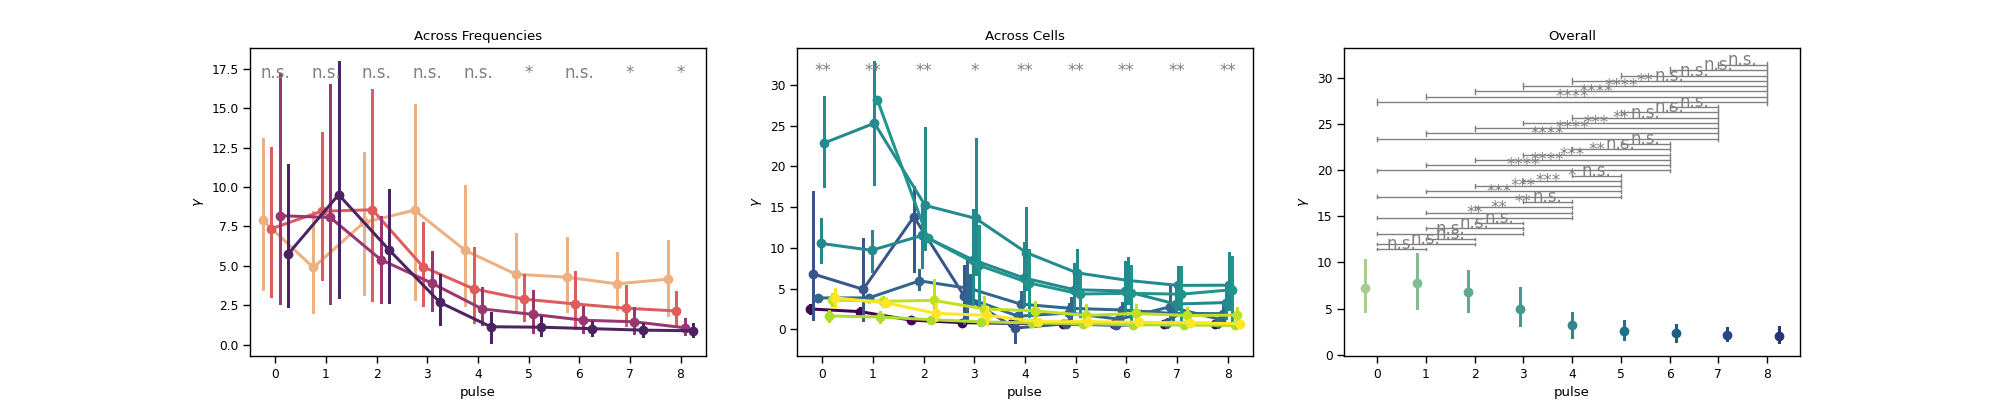

In [47]:
fig,ax = plt.subplots(1,3,figsize=(20,4), )
sampledf = fitdf[(fitdf['sample_size']>0)&(fitdf['observed']=='obs')&(fitdf['stimFreq']!=1000)&(fitdf['gamma']<50)]
# sns.pointplot(ax=ax[0], data=sampledf, x='pulse', y='gamma', hue='stimFreq', palette='flare', errorbar=('ci', 95))
# sns.pointplot(ax=ax[1], data=sampledf, x='pulse', y='gamma', hue='pulse', palette='crest', errorbar=('ci', 95))
importlib.reload(stat_annotate)
# stat annotate to check the statistical significance of the difference
# _ = stat_annotate.pairwise_annotate_violin_plot(ax[0], sampledf, x='pulse', y='gamma', stat=kruskal, add_line=True, offset=0.1, color='grey', coord_system='data', annotate='non-significant')
_ = stat_annotate.pairwise_draw_and_annotate_line_plot(ax[0], sampledf, x='pulse', y='gamma', hue='stimFreq', draw=True, kind='point', palette='flare', split_violins=False, dodge=0.5, stat_across='hue', stat=kruskal, skip_first_xvalue=False, annotate_wrt_data=False, offset_btw_star_n_line=0.1, color='grey', coord_system='data', fontsize=12, zorder=10, add_n=False)
_ = stat_annotate.pairwise_draw_and_annotate_line_plot(ax[1], sampledf, x='pulse', y='gamma', hue='cellID', draw=True, kind='point', palette='viridis', split_violins=False, dodge=0.5, stat_across='hue', stat=kruskal, skip_first_xvalue=False, annotate_wrt_data=False, offset_btw_star_n_line=0.1, color='grey', coord_system='data', fontsize=12, zorder=10, add_n=False)
_ = stat_annotate.pairwise_draw_and_annotate_line_plot(ax[2], sampledf, x='pulse', y='gamma', hue='pulse', draw=True, kind='point', palette='crest', split_violins=False, dodge=0.5, stat_across='x', stat=kruskal, skip_first_xvalue=False, annotate_wrt_data=False, offset_btw_star_n_line=0.1, color='grey', coord_system='data', fontsize=12, zorder=10, add_n=False)
ax[0].set_ylabel(r'$\gamma$')
ax[0].set_title('Across Frequencies')
ax[1].set_ylabel(r'$\gamma$')
ax[1].set_title('Across Cells')
ax[2].set_ylabel(r'$\gamma$')
ax[2].set_title('Overall')
# save fig
fig.savefig(paper_figure_export_location / 'Figure3_gamma_vs_pulse_across_freq_cellid_with_statistical_test.png', dpi=300, bbox_inches='tight')
fig.savefig(paper_figure_export_location / 'Figure3_gamma_vs_pulse_across_freq_cellid_with_statistical_test.svg', dpi=300, bbox_inches='tight')

0 7.163921796875001 [ 4.75990485 10.19982244]
1 7.6983184286794355 [ 4.79270462 11.1230806 ]
2 6.805026016971983 [4.80748422 9.30806496]
3 4.908310357142858 [3.28297952 7.02248465]
4 3.1064174517463234 [1.92390315 4.5936862 ]
5 2.561971271829044 [1.6896293  3.53244791]
6 2.3047947823660713 [1.52467994 3.23926039]
7 2.1508309841579862 [1.49011507 2.93531612]
8 1.9967649888392858 [1.32576001 2.9841072 ]


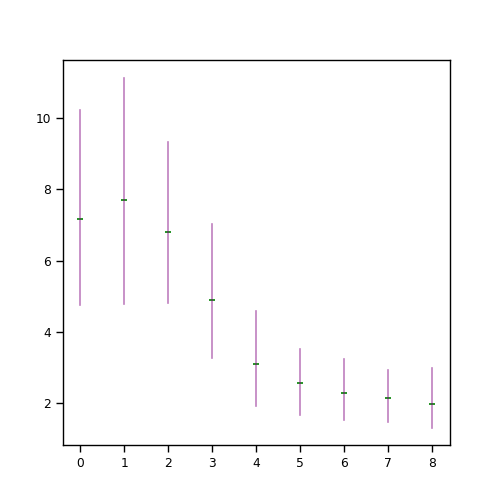

In [36]:
# bootstrap function
def bootstrap_gamma(data, n=1000):
    gamma_boot = []
    for i in range(n):
        gamma_boot.append(np.random.choice(data, size=len(data), replace=True).mean())
    return gamma_boot
fig,ax = plt.subplots(1,1,figsize=(5,5))
for p in range(9):    
# calculate gamma confidence interval for pulse 0
    sampledf = fitdf[(fitdf['sample_size']>0)&(fitdf['observed']=='obs')&(fitdf['pulse']==p)&(fitdf['stimFreq']!=1000)&(fitdf['gamma']<50)]
    
    gammas = sampledf['gamma'].values
    gamma_boot = bootstrap_gamma(gammas, n=1000)
    gamma_boot = np.array(gamma_boot)
    gamma_boot = np.sort(gamma_boot)

    # calculate 95% confidence interval
    gamma_ci = np.percentile(gamma_boot, [2.5, 97.5])
    median_gamma_boot = np.median(gamma_boot)
    print(p, median_gamma_boot, gamma_ci)

    ax.plot([p,p], gamma_ci, color='purple', alpha=0.5)
    ax.scatter(p, median_gamma_boot, color='green', marker="_")

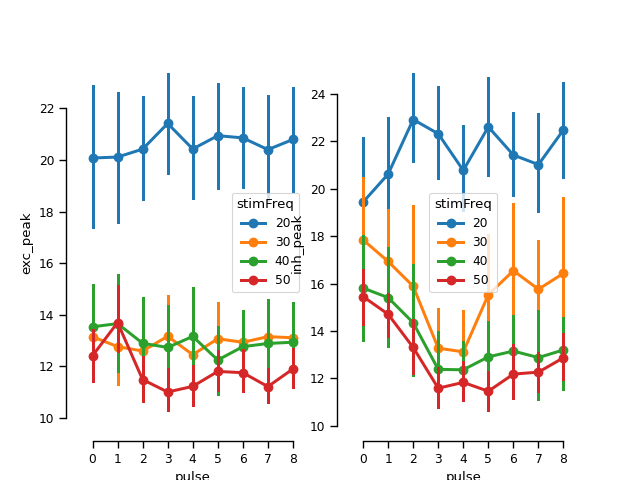

In [37]:
fig, [ax1,ax2]=plt.subplots(1,2)
sns.pointplot(data=vc_delay_df, x='pulse', y='exc_peak', hue='stimFreq', hue_order=[20,30,40,50], ax=ax1, palette='tab10', errorbar='ci',)
sns.pointplot(data=vc_delay_df, x='pulse', y='inh_peak', hue='stimFreq', hue_order=[20,30,40,50], ax=ax2, palette='tab10', errorbar='ci',)
# ax.set_ylim([-5,10])
sns.despine(ax=ax1, top=True, right=True, offset=10, trim=True)
sns.despine(ax=ax2, top=True, right=True, offset=10, trim=True)
# ax.legend([],[])

## Onset and Peak delays in CC and VC data

### Generate the delay dfs

In [13]:
def generate_cc_delay_df(cc_short_df):
    idvars = ['cellID','stimFreq','numSq','patternList','pulseWidth','intensity','trialID']

    valvars2a = [f'peakdelay_{i}' for i in freq_sweep_pulses]
    valvars2b = [f'onsetdelay_{i}' for i in freq_sweep_pulses]
    valvars2c = [f'normPSC_{i}' for i in freq_sweep_pulses]

    df2a = cc_short_df.melt(id_vars=idvars, 
                value_vars=valvars2a, 
                var_name='peak', value_name='peak_delay')

    df2b = cc_short_df.melt(id_vars=idvars, 
                value_vars=valvars2b, 
                var_name='onset', value_name='onset_delay')
    
    df2c = cc_short_df.melt(id_vars=idvars, 
                value_vars=valvars2c, 
                var_name='peakres', value_name='peak_PSP')

    df2a['pulse'] = df2a['peak' ].apply(lambda x: int(x.split('_')[-1]))
    df2b['pulse'] = df2b['onset'].apply(lambda x: int(x.split('_')[-1]))
    df2c['pulse'] = df2c['peakres'].apply(lambda x: int(x.split('_')[-1]))

    # # concat df1 and df2 on axis1
    cc_delay_df  = pd.merge(df2a,  df2b, on=['cellID','stimFreq','numSq','patternList','pulseWidth','intensity','trialID','pulse'], )
    cc_delay_df  = pd.merge(cc_delay_df,  df2c, on=['cellID','stimFreq','numSq','patternList','pulseWidth','intensity','trialID','pulse'], )
    # print('after merger: ', cc_delay_df.shape)

    # # remove those trials for which peak_delay and onset_delay are negative
    cc_delay_df.drop(columns=['peak','onset','peakres'], inplace=True)
    cc_delay_df = cc_delay_df[(cc_delay_df['peak_delay']>0) &(cc_delay_df['peak_delay']<0.05) ]
    cc_delay_df = cc_delay_df[(cc_delay_df['onset_delay']>0)&(cc_delay_df['onset_delay']<0.05) ]
    cc_delay_df = cc_delay_df[cc_delay_df['peak_delay'] > cc_delay_df['onset_delay']]
    cc_delay_df = cc_delay_df[(cc_delay_df['peak_PSP']>0)&(cc_delay_df['peak_PSP']<20) ]

    # print('after removing negative onset to peak times: ', cc_delay_df.shape)

    # cc_delay_df.drop(columns=['trialID'], inplace=True)
    # # drop NaNs in time_to_peak
    cc_delay_df = cc_delay_df.dropna(subset=['peak_delay','onset_delay', 'peak_PSP'])
    # print('merged and peak and onset calculated df: ', cc_delay_df.shape)
    columnscc = ['peak_delay','onset_delay']
    cc_delay_df[columnscc] = cc_delay_df[columnscc] * 1000

    print(cc_delay_df.shape)
    return cc_delay_df

def generate_vc_delay_df(vc_shortdf):    
    idvars = ['cellID','clampPotential','stimFreq','numSq','patternList','pulseWidth','intensity','trialID']

    valvars2a = [f'peakdelay_{i}' for i in freq_sweep_pulses]
    valvars2b = [f'onsetdelay_{i}' for i in freq_sweep_pulses]

    df2a = vc_shortdf.melt(id_vars=idvars, 
                value_vars=valvars2a, 
                var_name='peak', value_name='peak_delay')

    df2b = vc_shortdf.melt(id_vars=idvars, 
                value_vars=valvars2b, 
                var_name='onset', value_name='onset_delay')

    df2a['pulse'] = df2a['peak' ].apply(lambda x: int(x.split('_')[-1]))
    df2b['pulse'] = df2b['onset'].apply(lambda x: int(x.split('_')[-1]))

    # concat df1 and df2 on axis1
    df3  = pd.merge(df2a,  df2b, on=['cellID','clampPotential','stimFreq','numSq','patternList','pulseWidth','intensity','trialID','pulse'], )

    # remove those trials from df3 where time to peak is smaller than time to valley
    # remove those trials for which peak_onset and valley_onset are negative
    df3.drop(columns=['trialID'], inplace=True)
    df3.drop(columns=['onset','peak'], inplace=True)
    df3 = df3[(df3['peak_delay']>0) &(df3['peak_delay']<0.05)]
    df3 = df3[(df3['onset_delay']>0)&(df3['onset_delay']<0.05)]
    df3 = df3[ df3['peak_delay']    > df3['onset_delay']]
    # # drop NaNs in time_to_peak
    df3 = df3.dropna(subset=['peak_delay','onset_delay'])

    df4 = df3.groupby(['cellID','clampPotential','stimFreq','numSq','patternList','pulseWidth','intensity','pulse']).median().reset_index()
    # # pivot w.r.t clampPotential
    peak_delay_df  = df4.pivot(index=['cellID','stimFreq','numSq','patternList','pulseWidth','intensity','pulse'], columns='clampPotential', values='peak_delay').reset_index()
    onset_delay_df = df4.pivot(index=['cellID','stimFreq','numSq','patternList','pulseWidth','intensity','pulse'], columns='clampPotential', values='onset_delay').reset_index()

    # drop NaNs from df4pivot from columns -70 and 0
    peak_delay_df  = peak_delay_df.dropna(subset=[-70,0])
    onset_delay_df = onset_delay_df.dropna(subset=[-70,0])

    # # subtract -70 from 0
    peak_delay_df['peak_delayEI']   = (peak_delay_df[0]  - peak_delay_df[-70] )
    onset_delay_df['onset_delayEI'] = (onset_delay_df[0] - onset_delay_df[-70])

    # # rename -70 and 0 columns to exc_onset and inh_onset
    peak_delay_df.rename(columns={-70:'exc_peak', 0:'inh_peak'}, inplace=True)
    onset_delay_df.rename(columns={-70:'exc_onset', 0:'inh_onset'}, inplace=True)

    # # merge the two
    vc_delay_df = pd.merge(peak_delay_df, onset_delay_df, on=['cellID','stimFreq','numSq','patternList','pulseWidth','intensity','pulse'])
    # remove those rows where the onset delay is more than 20 or less than -20
    vc_delay_df = vc_delay_df[(vc_delay_df['onset_delayEI'] < 20) & (vc_delay_df['onset_delayEI'] > -20)]
    # multiply the delay by 1000 to convert to ms: following columns: 'exc_peak','inh_peak','peak_delayEI','exc_onset','inh_onset','onset_delayEI'
    columnsvc = ['exc_peak','inh_peak','peak_delayEI','exc_onset','inh_onset','onset_delayEI']
    vc_delay_df[columnsvc] = vc_delay_df[columnsvc] * 1000
    print(vc_delay_df.shape)
    return vc_delay_df

def generate_ebyi_df(vc_shortdf):
    idvars = ['cellID','clampPotential','stimFreq','numSq','patternList','pulseWidth','intensity','trialID']
    valvars = [f'normPSC_{i}' for i in freq_sweep_pulses]
    df2 = vc_shortdf.melt(id_vars=idvars, 
                value_vars=valvars, 
                var_name='pulse', value_name='PSC')

    # if clampPotential=-70, remove rows with positive PSC values
    # df2 = df2[((df2['clampPotential']==-70) & (df2['PSC']<0) & (df2['PSC']>-1000)) | ((df2['clampPotential']==0) & (df2['PSC']>0))]
    # df2 = df2[((df2['clampPotential']==-70) & (df2['PSC']<0) & (df2['PSC']>-1000)) | ((df2['clampPotential']==0) & (df2['PSC']>0))]

    df2['pulse'] = df2['pulse'].apply(lambda x: int(x.split('_')[-1]))
    df2 = df2.dropna(subset=['PSC'])
    df2.drop(columns=['trialID'], inplace=True)
    df2['numSq'] = df2['numSq'].astype('int')
    df4 = df2.groupby(['cellID','clampPotential','stimFreq','numSq','patternList','pulseWidth','intensity','pulse']).mean().reset_index()
    ebyi_df = df4.pivot(index=['cellID','stimFreq','numSq','patternList','pulseWidth','intensity','pulse'], columns='clampPotential', values='PSC').reset_index()
    ebyi_df = ebyi_df.dropna(subset=[-70,0])
    # ratio of -70 and 0
    # ebyi_df['EbyI'] = ( - ebyi_df[-70] / ebyi_df[0])
    ebyi_df['EbyI'] = ( ebyi_df[-70] / ebyi_df[0])
    ebyi_df = ebyi_df[(ebyi_df['EbyI'] < 20) & (ebyi_df['EbyI'] > 0)]

    print(ebyi_df.shape)
    return ebyi_df

In [14]:
cc_delay_df = generate_cc_delay_df(cc_FS_LTM_shortdf_slice)
vc_delay_df = generate_vc_delay_df(vc_FS_shortdf_slice)
ebyi_df     = generate_ebyi_df(vc_FS_shortdf_slice)

# save the dfs
cc_delay_df.to_hdf(paper_figure_export_location / "Figure3_delay_df_CC_FS.h5", key='data')
vc_delay_df.to_hdf(paper_figure_export_location / "Figure3_delay_df_VC_FS.h5", key='data')
ebyi_df.to_hdf(    paper_figure_export_location / "Figure3_ebyi_df_VC_FS.h5" , key='data')

(20544, 11)
(2296, 13)
(2886, 10)


C:\Users\Aditya\AppData\Local\Temp\ipykernel_18348\3090008323.py:6: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block3_values] [items->Index(['numSq', 'trialID'], dtype='object')]

  cc_delay_df.to_hdf(paper_figure_export_location / "Figure3_delay_df_CC_FS.h5", key='data')
C:\Users\Aditya\AppData\Local\Temp\ipykernel_18348\3090008323.py:8: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->axis0] [items->None]

  ebyi_df.to_hdf(    paper_figure_export_location / "Figure3_ebyi_df_VC_FS.h5" , key='data')
C:\Users\Aditya\AppData\Local\Temp\ipykernel_18348\3090008323.py:8: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block0_items] [items->None]

  ebyi_df.

### Load processed data

# Delay and E:I plots

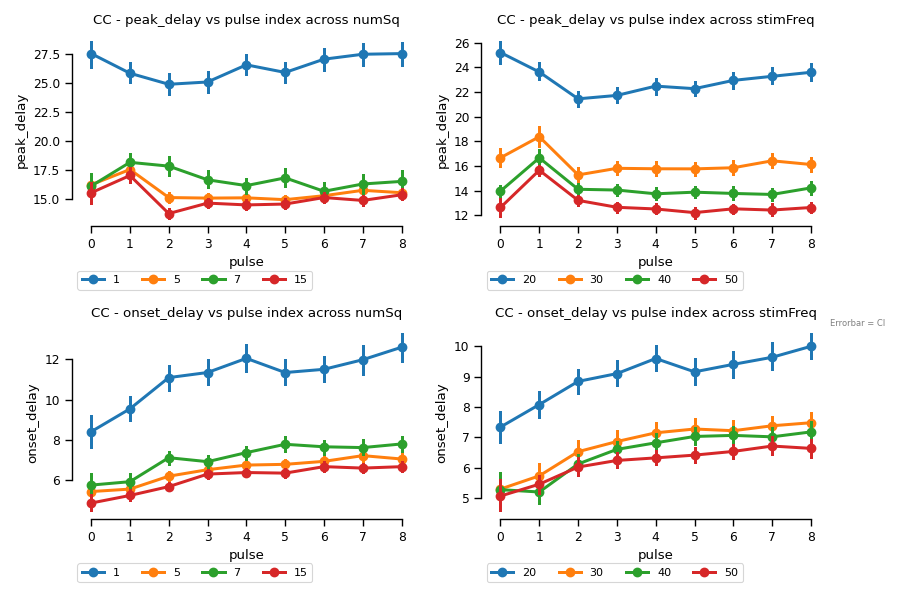

In [ ]:
fig, ax=plt.subplots(6,2, figsize=(9,12))
for j,prop in enumerate(['exc_peak','inh_peak','peak_delayEI','exc_onset','inh_onset','onset_delayEI']):
    for i,hue in enumerate(['numSq','stimFreq']):  
        sns.pointplot(data=vc_delay_df, x='pulse', y=prop, hue=hue, ax=ax[j,i], palette='tab10', errorbar='ci',)
        sns.despine(ax=ax[j,i], top=True, right=True, offset=0, trim=True)
        ax[j,i].set_title('VC - {} vs pulse index across {}'.format(prop, hue))
        # legend outside and above as horizontal line
        ax[j,i].legend(bbox_to_anchor=(0,-0.2), loc='upper left', ncol=4, fontsize='small')
        
ax[j,i].text(1.0,1.0, 'Errorbar = CI', transform=ax[j,i].transAxes, fontsize=6, color='grey')
#tight layout
fig.tight_layout()
fig.savefig(paper_figure_export_location / f'Figure3s14_VC_delays_vs_pulse.png', dpi=300, bbox_inches='tight')
fig.savefig(paper_figure_export_location / f'Figure3s14_VC_delays_vs_pulse.svg', dpi=300, bbox_inches='tight')

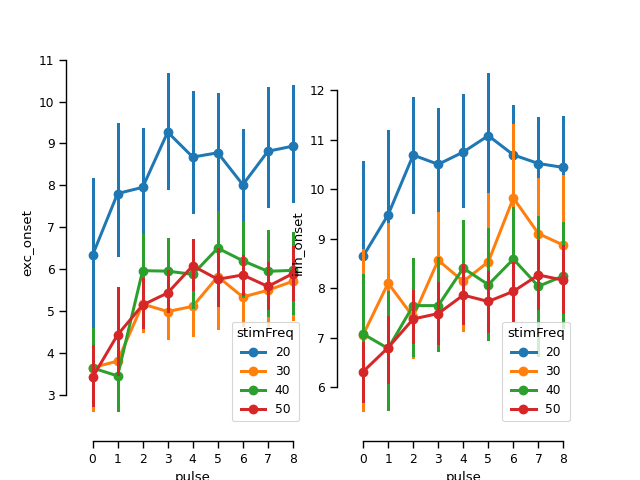

In [ ]:
fig, ax=plt.subplots(2,2, figsize=(9,6))
for j,prop in enumerate(['peak_delay','onset_delay']):
    for i,hue in enumerate(['numSq','stimFreq']):  
        sns.pointplot(data=cc_delay_df, x='pulse', y=prop, hue=hue, ax=ax[j,i], palette='tab10', errorbar='ci',)
        sns.despine(ax=ax[j,i], top=True, right=True, offset=0, trim=True)
        ax[j,i].set_title('CC - {} vs pulse index across {}'.format(prop, hue))
        # legend outside and above as horizontal line
        ax[j,i].legend(bbox_to_anchor=(0,-0.2), loc='upper left', ncol=4, fontsize='small')
        
ax[j,i].text(1.0,1.0, 'Errorbar = CI', transform=ax[j,i].transAxes, fontsize=6, color='grey')
#tight layout
fig.tight_layout()
fig.savefig(paper_figure_export_location / f'Figure3s14_CC_delays_vs_pulse.png', dpi=300, bbox_inches='tight')
fig.savefig(paper_figure_export_location / f'Figure3s14_CC_delays_vs_pulse.svg', dpi=300, bbox_inches='tight')

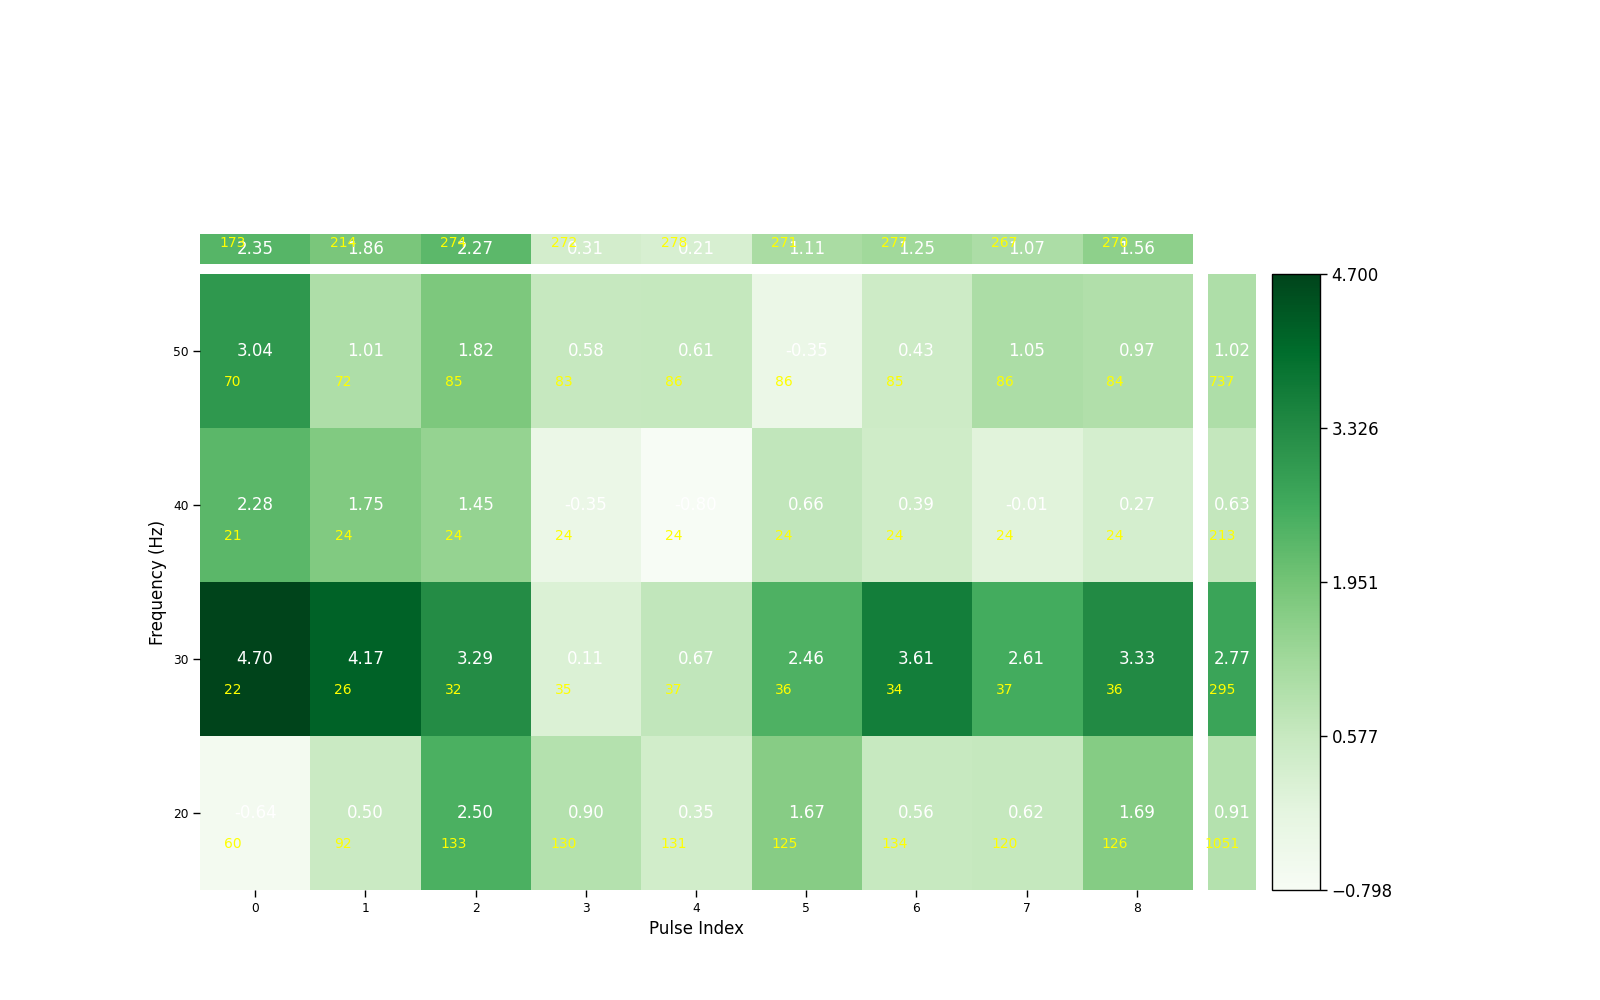

In [18]:
# plot heatmap of delay
Fig3s1, ax3s1 = plt.subplots(1,1, figsize=(16,10))
x       = vc_delay_df.groupby(['pulse', 'stimFreq']).mean().reset_index()
xpivot  = 1000*x.pivot(index='stimFreq', columns='pulse', values='peak_delayEI')
# print a matrix of number of trials for each condition
num_trials  = vc_delay_df.groupby(['pulse', 'stimFreq']).count().reset_index()
npivot      = num_trials.pivot(index='stimFreq', columns='pulse', values='peak_delayEI')
plot_tools.ax_to_partial_dist_heatmap_ax(xpivot, npivot, Fig3s1, ax3s1, barw=0.03, pad=0.01, shrink=0.8,  palette='Greens', force_vmin_to_zero=False, centralize_colorscale=False, annotate=True)
# save fig
Fig3s1.savefig(paper_figure_export_location / 'Figure3s1_EIdelay_peak_heatmap.png', dpi=300, bbox_inches='tight')
Fig3s1.savefig(paper_figure_export_location / 'Figure3s1_EIdelay_peak_heatmap.svg', dpi=300, bbox_inches='tight')

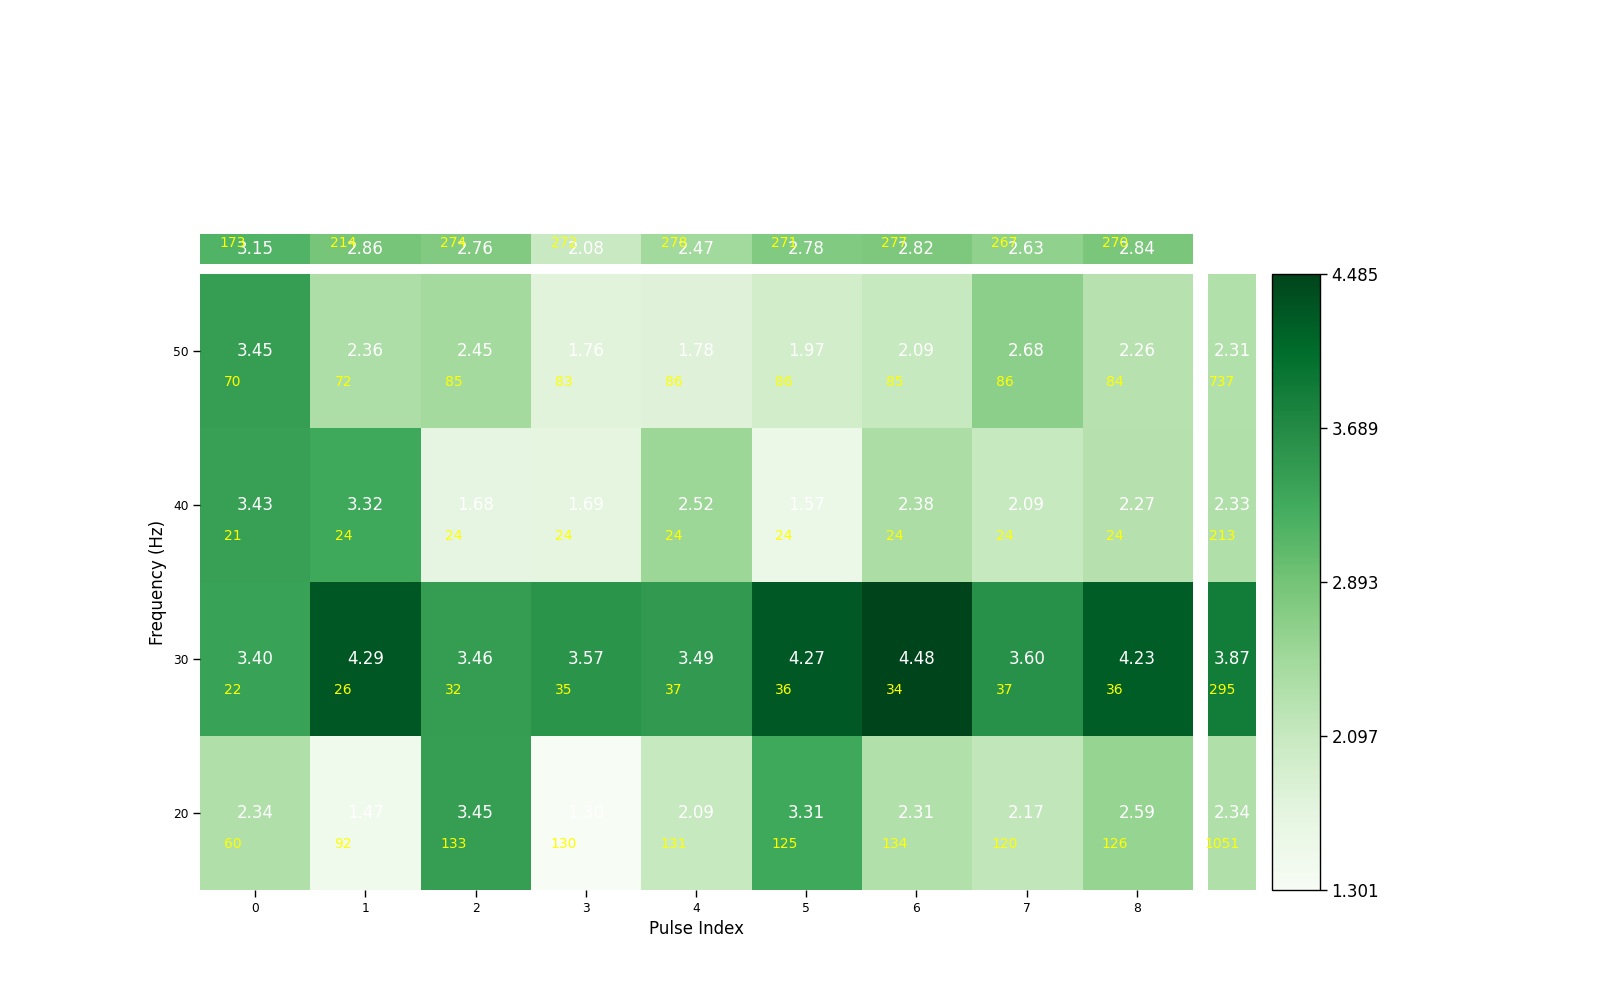

In [19]:
# plot heatmap of delay
Fig3s1, ax3s1 = plt.subplots(1,1, figsize=(16,10))
x       = vc_delay_df.groupby(['pulse', 'stimFreq']).mean().reset_index()
xpivot  = 1000*x.pivot(index='stimFreq', columns='pulse', values='onset_delayEI')
# print a matrix of number of trials for each condition
num_trials  = vc_delay_df.groupby(['pulse', 'stimFreq']).count().reset_index()
npivot      = num_trials.pivot(index='stimFreq', columns='pulse', values='onset_delayEI')
plot_tools.ax_to_partial_dist_heatmap_ax(xpivot, npivot, Fig3s1, ax3s1, barw=0.03, pad=0.01, shrink=0.8, palette='Greens', force_vmin_to_zero=False, centralize_colorscale=False, annotate=True)
# save fig
Fig3s1.savefig(paper_figure_export_location / 'Figure3s1_EIdelay_onset_heatmap.png', dpi=300, bbox_inches='tight')
Fig3s1.savefig(paper_figure_export_location / 'Figure3s1_EIdelay_onset_heatmap.svg', dpi=300, bbox_inches='tight')

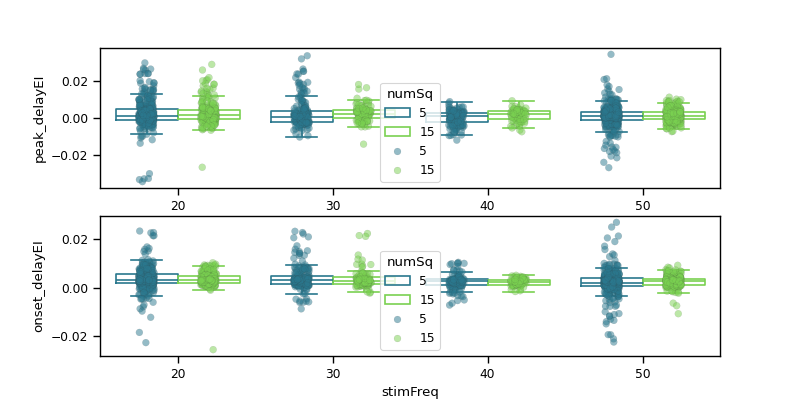

In [20]:
# box plot of delayEI across numSq and stimFreq
fig3s2, ax3s2 = plt.subplots(2,1, figsize=(8,4))
sns.boxplot(data=vc_delay_df, x='stimFreq', y='peak_delayEI', hue='numSq', hue_order=[5,15], dodge=True, ax=ax3s2[0], palette=color_squares, fliersize=0, fill=False)
sns.stripplot(data=vc_delay_df, x='stimFreq', y='peak_delayEI', hue='numSq', hue_order=[5,15], dodge=True, ax=ax3s2[0], palette=color_squares, linewidth=0.1, alpha=0.5)
sns.boxplot(data=vc_delay_df, x='stimFreq', y='onset_delayEI', hue='numSq', hue_order=[5,15], dodge=True, ax=ax3s2[1], palette=color_squares, fliersize=0, fill=False)
sns.stripplot(data=vc_delay_df, x='stimFreq', y='onset_delayEI', hue='numSq', hue_order=[5,15], dodge=True, ax=ax3s2[1], palette=color_squares, linewidth=0.1, alpha=0.5)
#save fig
fig3s2.savefig(paper_figure_export_location / 'Figure3s2_EIdelay_vsfreq_vsnumSq_boxstripplot.png', dpi=300, bbox_inches='tight')
fig3s2.savefig(paper_figure_export_location / 'Figure3s2_EIdelay_vsfreq_vsnumSq_boxstripplot.svg', dpi=300, bbox_inches='tight')

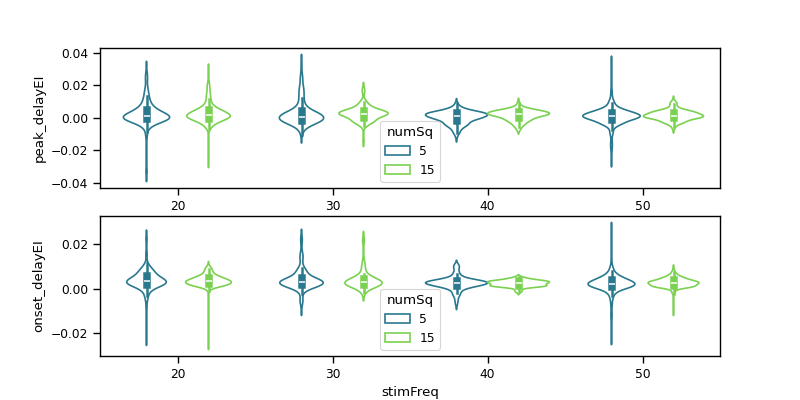

In [21]:
# box plot of delayEI across numSq and stimFreq
fig3s2, ax3s2 = plt.subplots(2,1, figsize=(8,4))
sns.violinplot(data=vc_delay_df, x='stimFreq', y='peak_delayEI', hue='numSq', hue_order=[5,15], dodge=True, ax=ax3s2[0], palette=color_squares, fill=False)
# sns.stripplot(data=vc_delay_df, x='stimFreq', y='peak_delayEI', hue='numSq', hue_order=[5,15], dodge=True, ax=ax3s2[0], palette=color_squares, linewidth=0.1, alpha=0.5)
sns.violinplot(data=vc_delay_df, x='stimFreq', y='onset_delayEI', hue='numSq', hue_order=[5,15], dodge=True, ax=ax3s2[1], palette=color_squares, fill=False)
# sns.stripplot(data=vc_delay_df, x='stimFreq', y='onset_delayEI', hue='numSq', hue_order=[5,15], dodge=True, ax=ax3s2[1], palette=color_squares, linewidth=0.1, alpha=0.5)
#save fig
fig3s2.savefig(paper_figure_export_location / 'Figure3s2_EIdelay_vsfreq_vsnumSq_violin.png', dpi=300, bbox_inches='tight')
fig3s2.savefig(paper_figure_export_location / 'Figure3s2_EIdelay_vsfreq_vsnumSq_violin.svg', dpi=300, bbox_inches='tight')

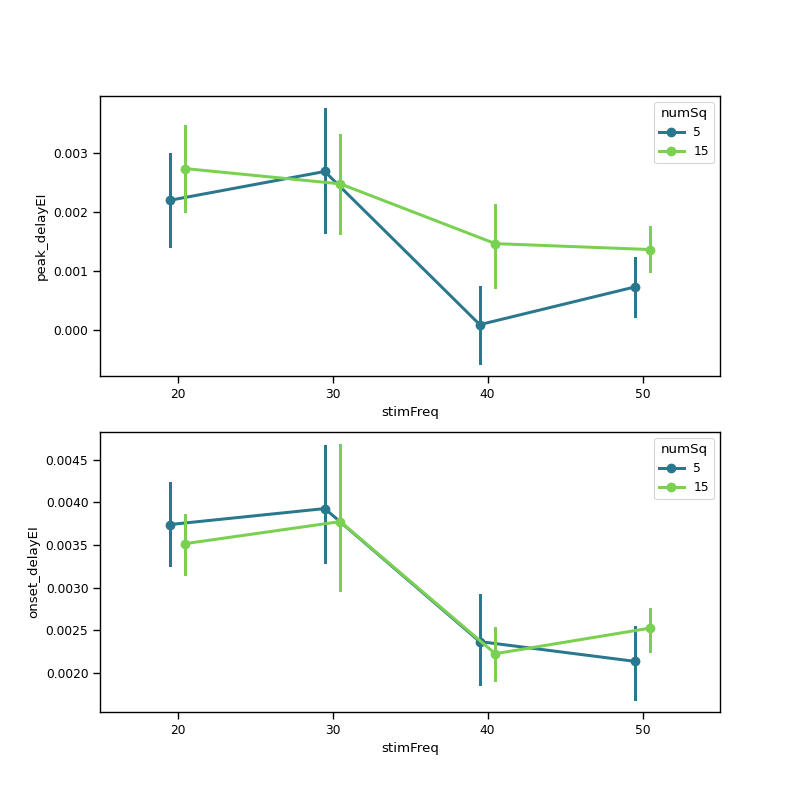

In [22]:
# box plot of delayEI across numSq and stimFreq
fig3s3, ax3s3 = plt.subplots(2,1, figsize=(8,8))
sns.pointplot(data=vc_delay_df, x='stimFreq', y='peak_delayEI', hue='numSq', hue_order=[5,15], ax=ax3s3[0], palette=color_squares, dodge=0.1)
sns.pointplot(data=vc_delay_df, x='stimFreq', y='onset_delayEI', hue='numSq', hue_order=[5,15], ax=ax3s3[1], palette=color_squares, dodge=0.1)
#save fig
fig3s3.savefig(paper_figure_export_location / 'Figure3s3_EIdelay_vsfreq_vsnumSq_pointplot.png', dpi=300, bbox_inches='tight')
fig3s3.savefig(paper_figure_export_location / 'Figure3s3_EIdelay_vsfreq_vsnumSq_pointplot.svg', dpi=300, bbox_inches='tight')

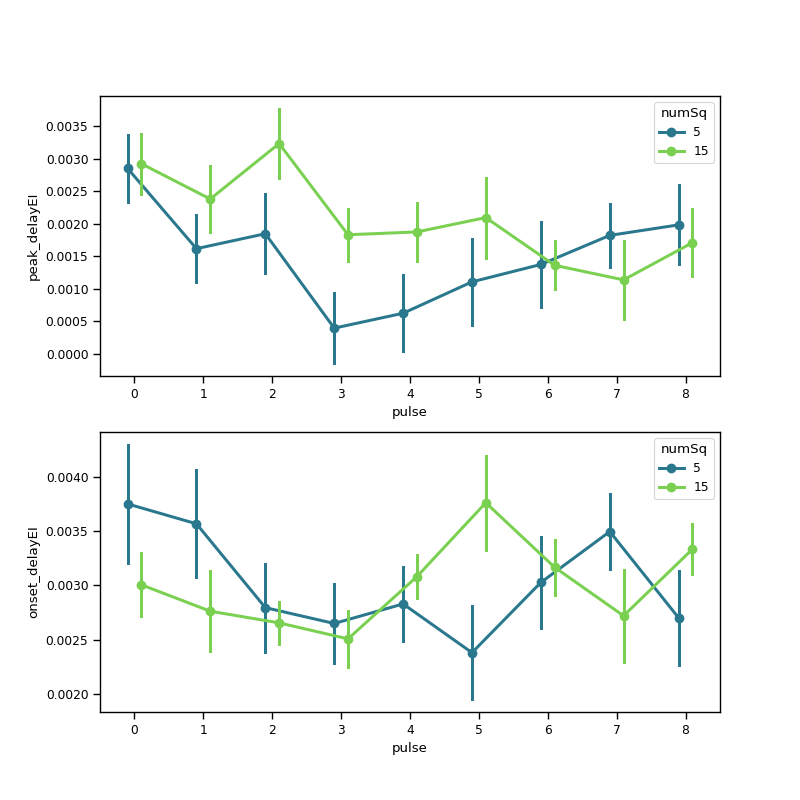

In [23]:
# box plot of delayEI across numSq and stimFreq
fig3s4, ax3s4 = plt.subplots(2,1, figsize=(8,8))
sns.pointplot(data=vc_delay_df, x='pulse', y='peak_delayEI', hue='numSq', hue_order=[5,15], ax=ax3s4[0], palette=color_squares, errorbar='se', dodge=0.2)
sns.pointplot(data=vc_delay_df, x='pulse', y='onset_delayEI', hue='numSq', hue_order=[5,15], ax=ax3s4[1], palette=color_squares, errorbar='se', dodge=0.2)
# save fig
fig3s4.savefig(paper_figure_export_location / 'Figure3s4_EIdelay_vspulse_vsnumsq.png', dpi=300, bbox_inches='tight')
fig3s4.savefig(paper_figure_export_location / 'Figure3s4_EIdelay_vspulse_vsnumsq.svg', dpi=300, bbox_inches='tight')

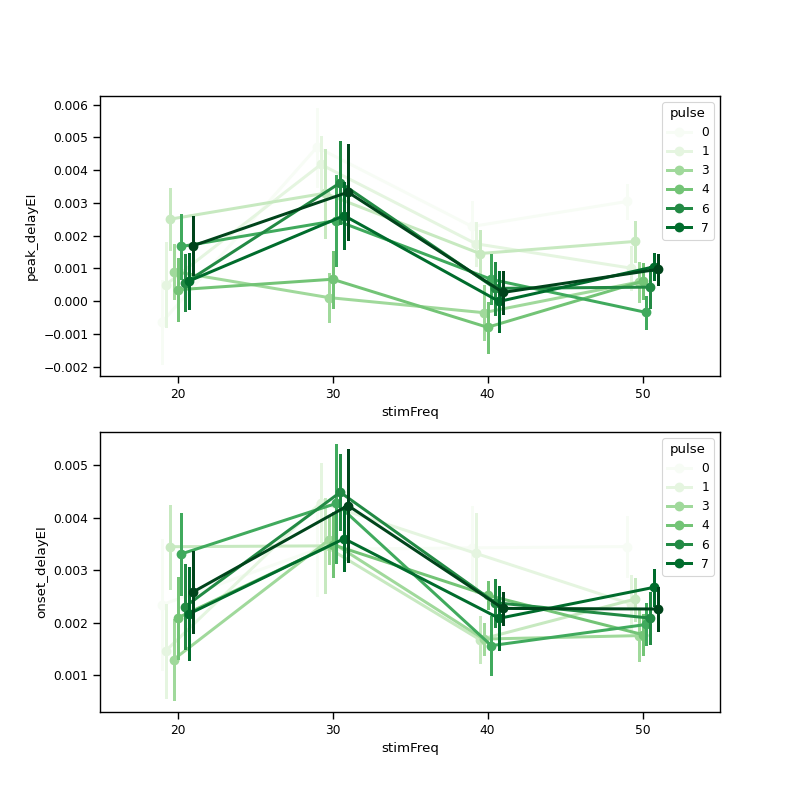

In [24]:
# box plot of delayEI across numSq and stimFreq
fig3s5, ax3s5 = plt.subplots(2,1, figsize=(8,8))
sns.pointplot(data=vc_delay_df, hue='pulse', y='peak_delayEI', x='stimFreq', hue_order=[20,30,40,50], ax=ax3s5[0], palette='Greens', errorbar='se', dodge=0.2)
sns.pointplot(data=vc_delay_df, hue='pulse', y='onset_delayEI', x='stimFreq', hue_order=[20,30,40,50], ax=ax3s5[1], palette='Greens', errorbar='se', dodge=0.2)
# save fig
fig3s5.savefig(paper_figure_export_location / 'Figure3s5a_EIdelay_vspulse_vsstimFreq.png', dpi=300, bbox_inches='tight')
fig3s5.savefig(paper_figure_export_location / 'Figure3s5a_EIdelay_vspulse_vsstimFreq.svg', dpi=300, bbox_inches='tight')

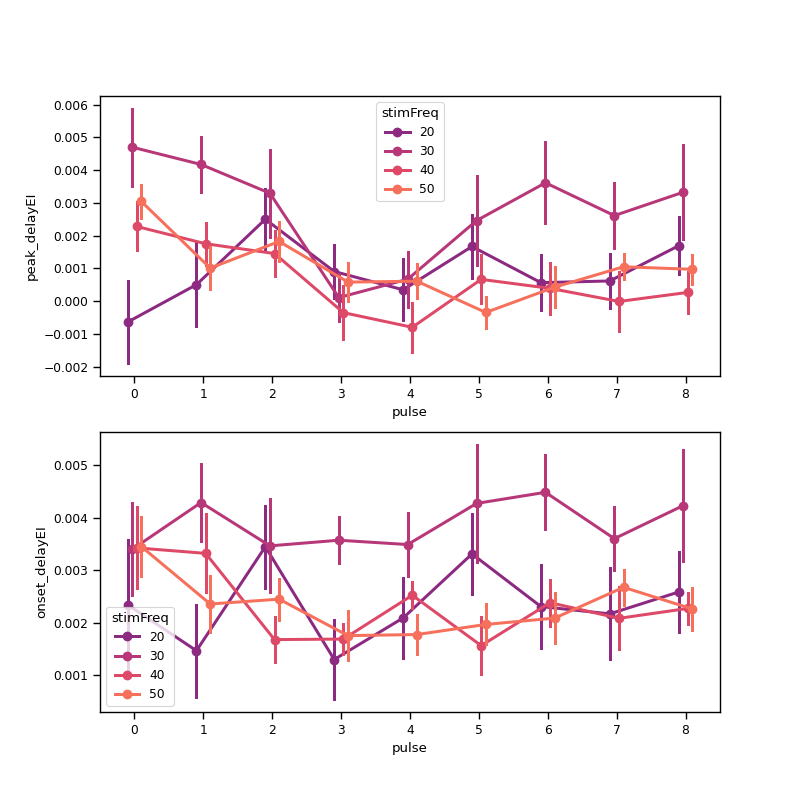

In [25]:
# box plot of delayEI across numSq and stimFreq
fig3s5, ax3s5 = plt.subplots(2,1, figsize=(8,8))
sns.pointplot(data=vc_delay_df, x='pulse', y='peak_delayEI', hue='stimFreq', hue_order=[20,30,40,50], ax=ax3s5[0], palette=color_freq, errorbar='se', dodge=0.2)
sns.pointplot(data=vc_delay_df, x='pulse', y='onset_delayEI', hue='stimFreq', hue_order=[20,30,40,50], ax=ax3s5[1], palette=color_freq, errorbar='se', dodge=0.2)
# save fig
fig3s5.savefig(paper_figure_export_location / 'Figure3s5_EIdelay_vspulse_vsstimFreq.png', dpi=300, bbox_inches='tight')
fig3s5.savefig(paper_figure_export_location / 'Figure3s5_EIdelay_vspulse_vsstimFreq.svg', dpi=300, bbox_inches='tight')

## EbyI ratio from VC data

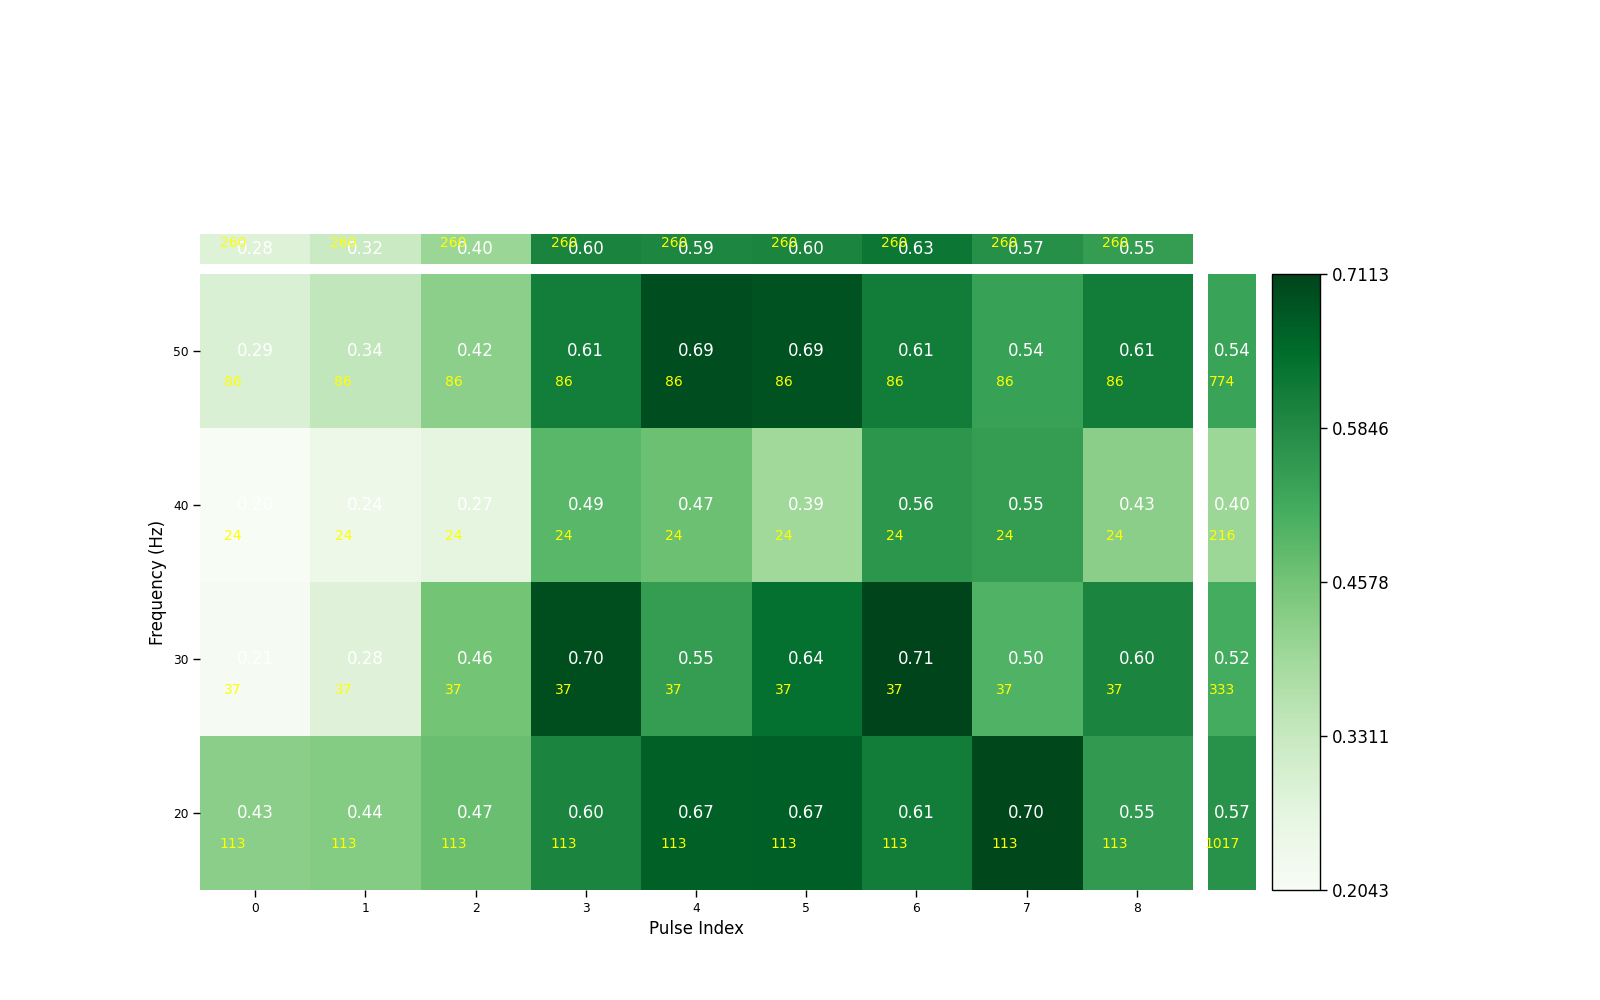

In [26]:
Fig3s6, ax3s6 = plt.subplots(1,1, figsize=(16,10))
x = ebyi_df.groupby(['pulse', 'stimFreq']).median().reset_index()
xpivot = x.pivot(index='stimFreq', columns='pulse', values='EbyI')
# print a matrix of number of trials for each condition
num_trials = ebyi_df.groupby(['pulse', 'stimFreq']).count().reset_index()
npivot = num_trials.pivot(index='stimFreq', columns='pulse', values='EbyI')
plot_tools.ax_to_partial_dist_heatmap_ax(xpivot, npivot, Fig3s6, ax3s6, barw=0.03, pad=0.01, shrink=0.8, palette='Greens', force_vmin_to_zero=False, centralize_colorscale=False, annotate=True)
# save fig
Fig3s6.savefig(paper_figure_export_location / 'Figure3s6_EbyI_heatmap_median.png', dpi=300, bbox_inches='tight')
Fig3s6.savefig(paper_figure_export_location / 'Figure3s6_EbyI_heatmap_median.svg', dpi=300, bbox_inches='tight')

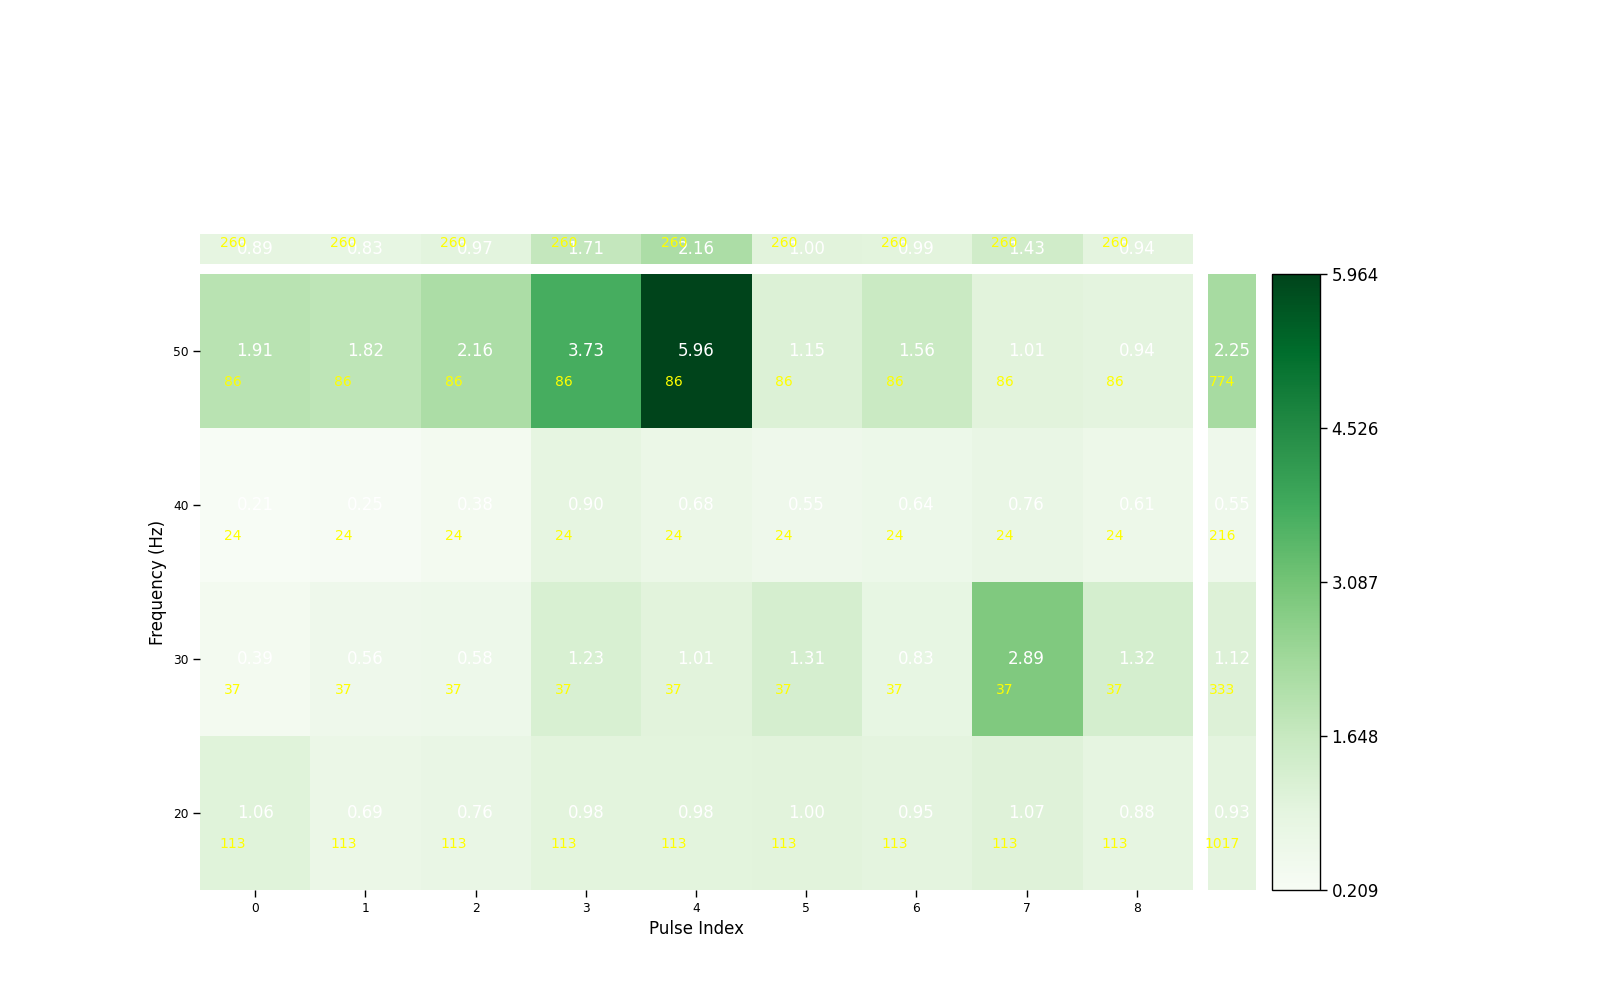

In [27]:
Fig3s7, ax3s7 = plt.subplots(1,1, figsize=(16,10))
x = ebyi_df.groupby(['pulse', 'stimFreq']).mean().reset_index()
xpivot = x.pivot(index='stimFreq', columns='pulse', values='EbyI')
# print a matrix of number of trials for each condition
num_trials = ebyi_df.groupby(['pulse', 'stimFreq']).count().reset_index()
npivot = num_trials.pivot(index='stimFreq', columns='pulse', values='EbyI')
plot_tools.ax_to_partial_dist_heatmap_ax(xpivot, npivot, Fig3s7, ax3s7, barw=0.03, pad=0.01, shrink=0.8, palette='Greens', force_vmin_to_zero=False, centralize_colorscale=False, annotate=True)
# save fig
Fig3s7.savefig(paper_figure_export_location / 'Figure3s7_EbyI_heatmap_mean.png', dpi=300, bbox_inches='tight')
Fig3s7.savefig(paper_figure_export_location / 'Figure3s7_EbyI_heatmap_mean.svg', dpi=300, bbox_inches='tight')

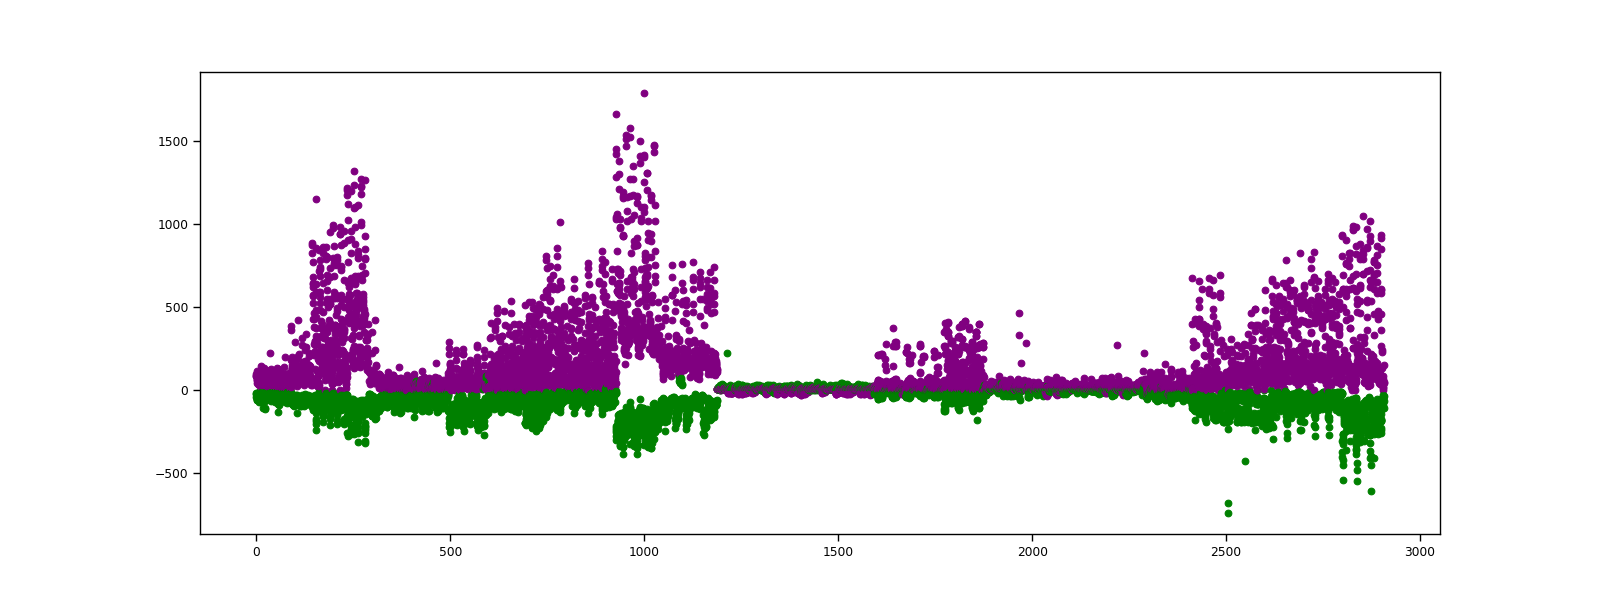

In [104]:
fig3s8, ax3s8 = plt.subplots(1,1, figsize=(16,6))
counter = 0
for cell in np.sort(df2['cellID'].unique()):
    for pat in np.sort(df2['patternList'].unique()):
        for f in np.sort(df2['stimFreq'].unique()):
            for p in np.sort(df2['pulse'].unique()):
                for pw in np.sort(df2['pulseWidth'].unique()):
                    for inten in np.sort(df2['intensity'].unique()):
                        dftemp = df2[(df2['cellID']==cell) & (df2['patternList']==pat) & (df2['stimFreq']==f) & (df2['pulse']==p) & (df2['pulseWidth']==pw) & (df2['intensity']==inten)]
                        if dftemp.shape[0] == 0:
                            continue
                        excn = dftemp[dftemp['clampPotential']==-70].dropna(subset=['PSC'])
                        inhn = dftemp[dftemp['clampPotential']==0].dropna(subset=['PSC'])
                        if (excn.shape[0] == 0) | (inhn.shape[0] == 0):
                            continue
                        exc, inh = excn['PSC'].values, inhn['PSC'].values
                        exc = np.where(exc <-1000, exc/20, exc)
                        for i in exc:
                            ax3s8.scatter(counter, i, color='green')
                        for i in inh:
                            ax3s8.scatter(counter, i, color='purple')
                        counter +=1

fig3s8.savefig(paper_figure_export_location / 'Figure3s8_EbyI_scatter_trial_by_trial.png', dpi=300, bbox_inches='tight')
fig3s8.savefig(paper_figure_export_location / 'Figure3s8_EbyI_scatter_trial_by_trial.svg', dpi=300, bbox_inches='tight')

In [99]:
trialwise_dict = []
for cell in np.sort(df2['cellID'].unique()):
    for pat in np.sort(df2['patternList'].unique()):
        for f in np.sort(df2['stimFreq'].unique()):
            for p in np.sort(df2['pulse'].unique()):
                for pw in np.sort(df2['pulseWidth'].unique()):
                    for inten in np.sort(df2['intensity'].unique()):
                        dftemp = df2[(df2['cellID']==cell) & (df2['patternList']==pat) & (df2['stimFreq']==f) & (df2['pulse']==p) & (df2['pulseWidth']==pw) & (df2['intensity']==inten)]
                        if dftemp.shape[0] == 0:
                            continue
                        excn = dftemp[dftemp['clampPotential']==-70].dropna(subset=['PSC'])
                        inhn = dftemp[dftemp['clampPotential']==0].dropna(subset=['PSC'])
                        numSq = dftemp['numSq'].values[0]
                        if (excn.shape[0] == 0) | (inhn.shape[0] == 0):
                            continue
                        exc, inh = excn['PSC'].values, inhn['PSC'].values
                        exc = np.where(exc <-1000, exc/20, exc)
                        max_exc = np.max(exc)
                        trialwise_dict.append({'cellID':cell, 'patternList':pat, 'numSq':numSq,'stimFreq':f, 'pulse':p, 'pulseWidth':pw, 'intensity':inten, 'max_exc':max_exc, 'exc':exc, 'inh':inh})

trialwise_df = pd.DataFrame(trialwise_dict)
# step 1: add a column that gives the absolute descending order of max_exc
trialwise_df['max_exc_rank'] = trialwise_df['max_exc'].rank(ascending=False)
# step2: explode exc and inh columns
trialwise_df = utils.expand_list_column(trialwise_df, 'exc', 'exc')
trialwise_df = utils.expand_list_column(trialwise_df, 'inh', 'inh')
# drop exc and inh columns
trialwise_df.drop(columns=['exc','inh'], inplace=True)

input df shape:  (2907, 11) num of new columns:  3
new columns:  ['exc0', 'exc1', 'exc2'] 2907 3
(2907, 3) (2907, 14)
input df shape:  (2907, 14) num of new columns:  3
new columns:  ['inh0', 'inh1', 'inh2'] 2907 3
(2907, 3) (2907, 17)


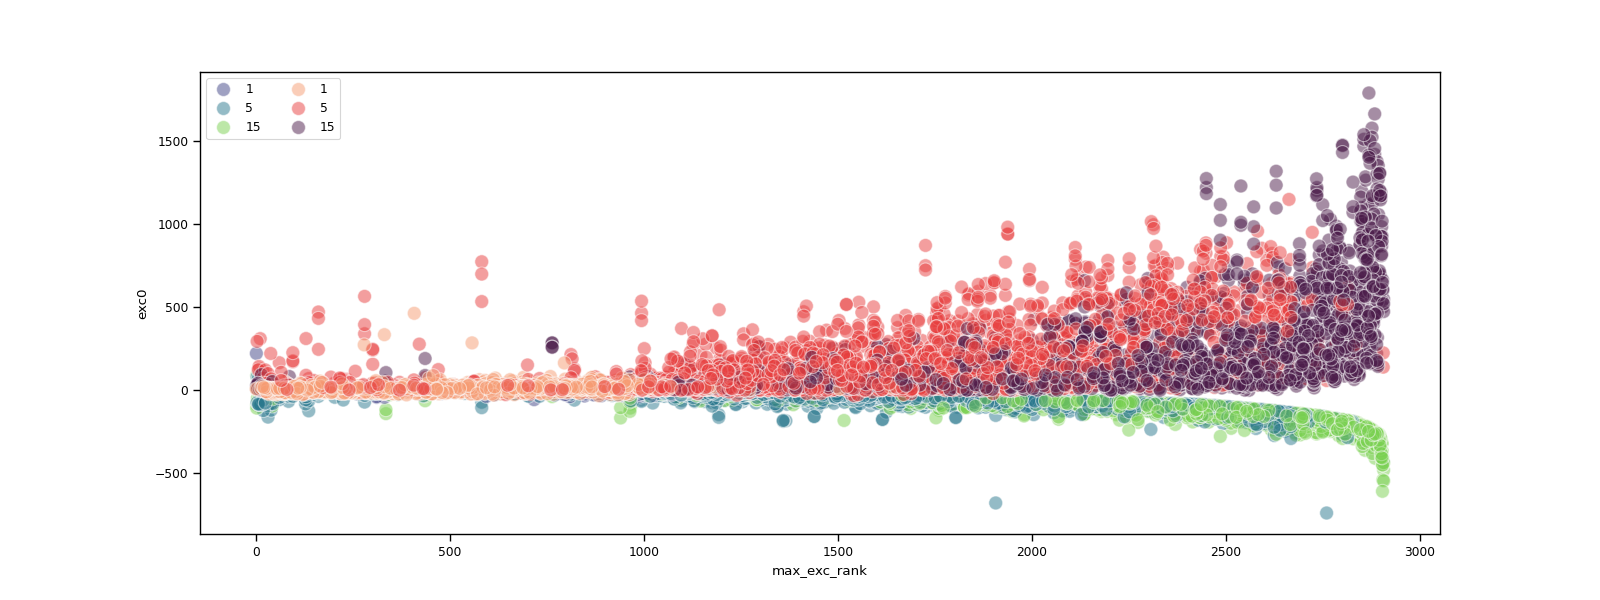

In [100]:
fig3s8b, ax3s8b = plt.subplots(1,1, figsize=(16,6))
sns.scatterplot(data=trialwise_df, x='max_exc_rank', y='exc0', hue='numSq', s=100, alpha=0.5, palette=color_squares, ax=ax3s8b, legend=False)
sns.scatterplot(data=trialwise_df, x='max_exc_rank', y='exc1', hue='numSq', s=100, alpha=0.5, palette=color_squares, ax=ax3s8b, legend=False)
sns.scatterplot(data=trialwise_df, x='max_exc_rank', y='exc2', hue='numSq', s=100, alpha=0.5, palette=color_squares, ax=ax3s8b)

sns.scatterplot(data=trialwise_df, x='max_exc_rank', y='inh0', hue='numSq', s=100, alpha=0.5, palette=color_squares_r, ax=ax3s8b, legend=False)
sns.scatterplot(data=trialwise_df, x='max_exc_rank', y='inh1', hue='numSq', s=100, alpha=0.5, palette=color_squares_r, ax=ax3s8b, legend=False)
sns.scatterplot(data=trialwise_df, x='max_exc_rank', y='inh2', hue='numSq', s=100, alpha=0.5, palette=color_squares_r, ax=ax3s8b)

ax3s8b.legend(loc='upper left', ncols=2)

fig3s8b.savefig(paper_figure_export_location / 'Figure3s8b_EbyI_scatter_trial_by_trial_vsnumSq.png', dpi=300, bbox_inches='tight')
fig3s8b.savefig(paper_figure_export_location / 'Figure3s8b_EbyI_scatter_trial_by_trial_vsnumSq.svg', dpi=300, bbox_inches='tight')

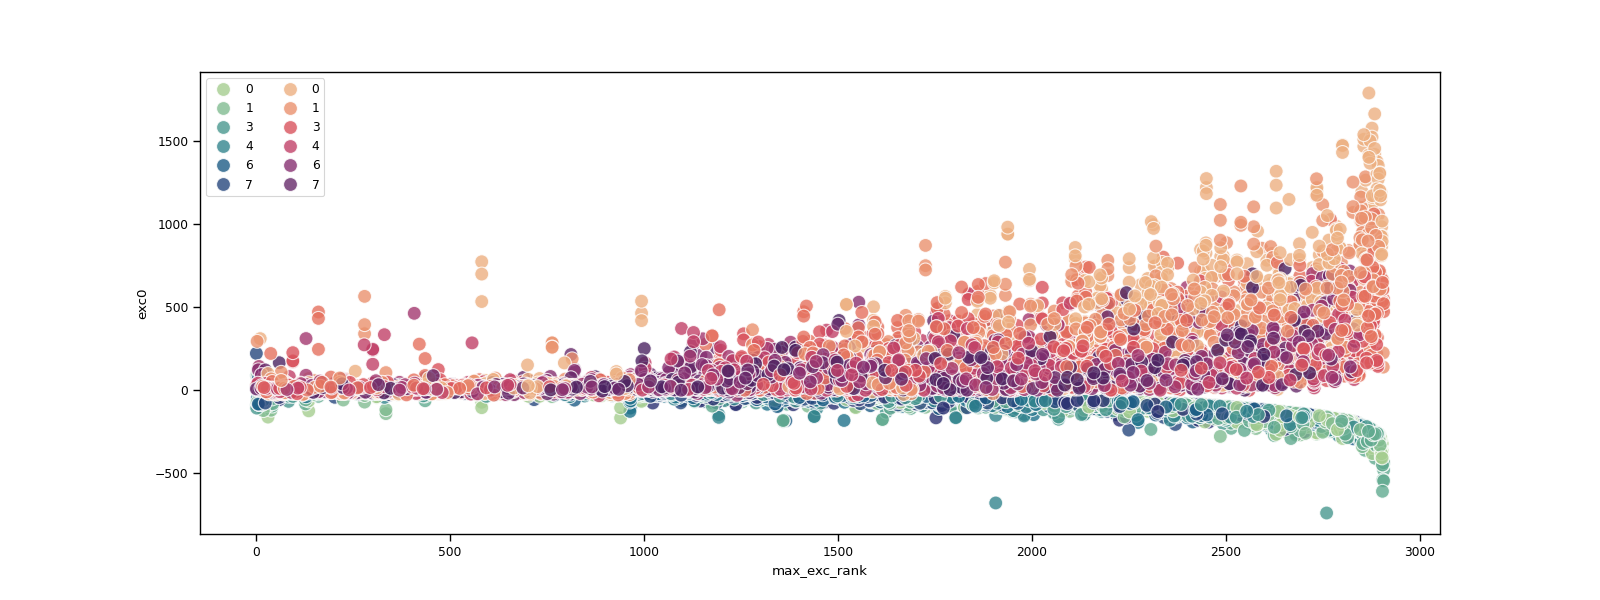

In [101]:
fig3s8c, ax3s8c = plt.subplots(1,1, figsize=(16,6))
sns.scatterplot(data=trialwise_df, x='max_exc_rank', y='exc0', hue='pulse', s=100, alpha=0.8, palette=crest, ax=ax3s8c, legend=False)
sns.scatterplot(data=trialwise_df, x='max_exc_rank', y='exc1', hue='pulse', s=100, alpha=0.8, palette=crest, ax=ax3s8c, legend=False)
sns.scatterplot(data=trialwise_df, x='max_exc_rank', y='exc2', hue='pulse', s=100, alpha=0.8, palette=crest, ax=ax3s8c)

sns.scatterplot(data=trialwise_df, x='max_exc_rank', y='inh0', hue='pulse', s=100, alpha=0.8, palette=flare, ax=ax3s8c, legend=False)
sns.scatterplot(data=trialwise_df, x='max_exc_rank', y='inh1', hue='pulse', s=100, alpha=0.8, palette=flare, ax=ax3s8c, legend=False)
sns.scatterplot(data=trialwise_df, x='max_exc_rank', y='inh2', hue='pulse', s=100, alpha=0.8, palette=flare, ax=ax3s8c)

ax3s8c.legend(loc='upper left', ncols=2)

fig3s8c.savefig(paper_figure_export_location / 'Figure3s8c_EbyI_scatter_trial_by_trial_vspulse.png', dpi=300, bbox_inches='tight')
fig3s8c.savefig(paper_figure_export_location / 'Figure3s8c_EbyI_scatter_trial_by_trial_vspulse.svg', dpi=300, bbox_inches='tight')

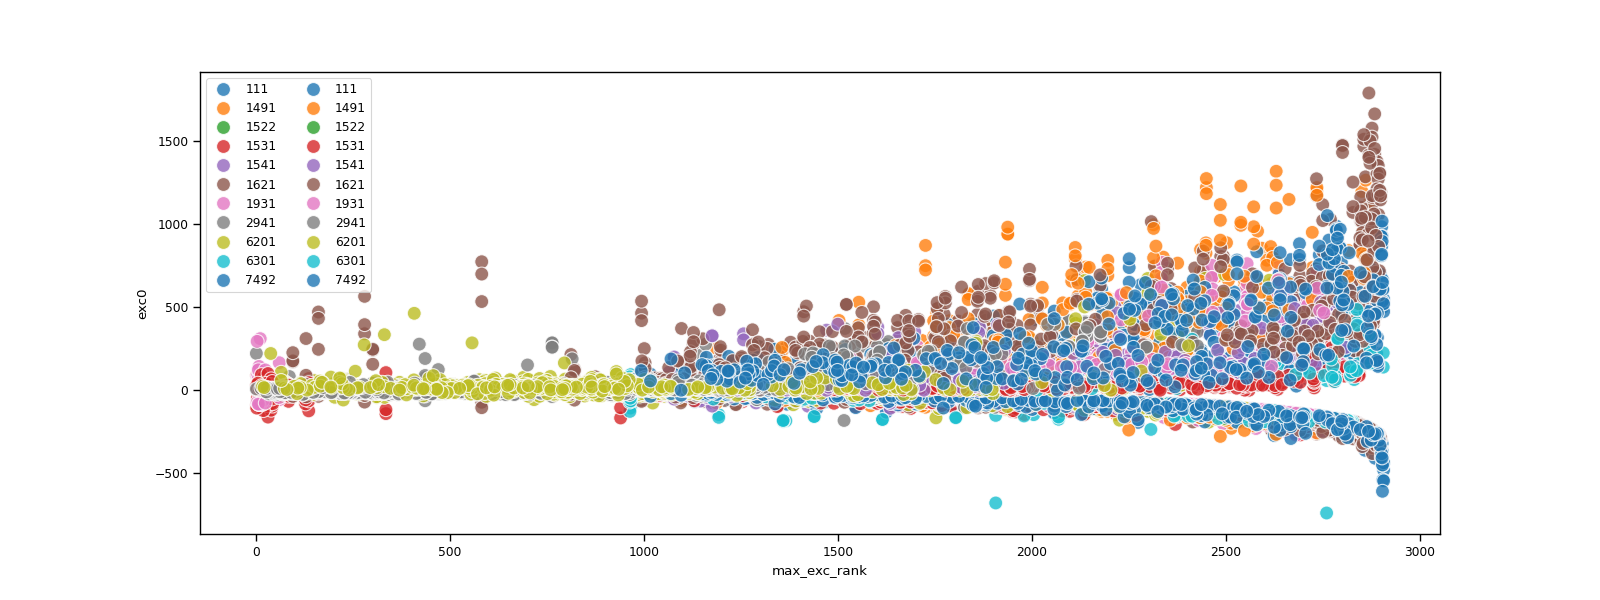

In [102]:
fig3s8d, ax3s8d = plt.subplots(1,1, figsize=(16,6))
sns.scatterplot(data=trialwise_df, x='max_exc_rank', y='exc0', hue='cellID', s=100, alpha=0.8, palette="tab10", ax=ax3s8d, legend=False)
sns.scatterplot(data=trialwise_df, x='max_exc_rank', y='exc1', hue='cellID', s=100, alpha=0.8, palette="tab10", ax=ax3s8d, legend=False)
sns.scatterplot(data=trialwise_df, x='max_exc_rank', y='exc2', hue='cellID', s=100, alpha=0.8, palette="tab10", ax=ax3s8d)

sns.scatterplot(data=trialwise_df, x='max_exc_rank', y='inh0', hue='cellID', s=100, alpha=0.8, palette="tab10", ax=ax3s8d, legend=False)
sns.scatterplot(data=trialwise_df, x='max_exc_rank', y='inh1', hue='cellID', s=100, alpha=0.8, palette="tab10", ax=ax3s8d, legend=False)
sns.scatterplot(data=trialwise_df, x='max_exc_rank', y='inh2', hue='cellID', s=100, alpha=0.8, palette="tab10", ax=ax3s8d)

ax3s8d.legend(loc='upper left', ncols=2)

fig3s8d.savefig(paper_figure_export_location / 'Figure3s8d_EbyI_scatter_trial_by_trial_vscellID.png', dpi=300, bbox_inches='tight')
fig3s8d.savefig(paper_figure_export_location / 'Figure3s8d_EbyI_scatter_trial_by_trial_vscellID.svg', dpi=300, bbox_inches='tight')

In [28]:
def linear_func(x, m, c):
    return m*x + c

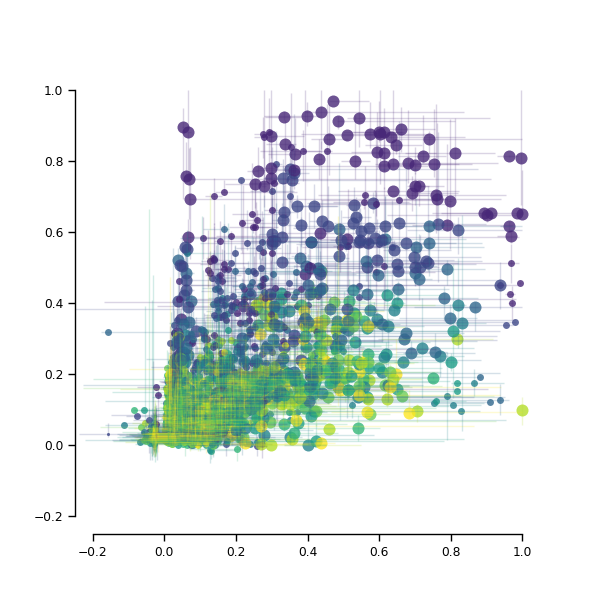

In [136]:
cells = [ 111, 1491, 1531, 1541, 1621, 1931, 6201, 6301,7492] # VC cells with at least one freq data
freqs = np.sort(df2['stimFreq'].unique())
# fig3s9, ax3s9 = plt.subplots(len(cells), len(freqs), figsize=(12,30), sharex=False, sharey=False)
fig3s9b, ax3s9b = plt.subplots(1,1, figsize=(6,6), sharex=False, sharey=False)
dflist = []
success_counter = 0
total_counter = 0
for c, cell in enumerate(cells):
    # get the highest value of exc and inh for this cell
    maxE = df2[(df2['cellID']==cell) & (df2['clampPotential']==-70)].dropna(subset=['PSC'])['PSC'].min()
    maxI = df2[(df2['cellID']==cell) & (df2['clampPotential']==  0)].dropna(subset=['PSC'])['PSC'].max()
    for f, freq in enumerate(freqs):
        for p in range(9):
            pulsewiselistE = []
            pulsewiselistI = []
            for pat in np.sort(df2['patternList'].unique()):
                for pw in np.sort(df2['pulseWidth'].unique()):
                    for inten in np.sort(df2['intensity'].unique()):
                        total_counter += 1
                        dftemp = df2[(df2['cellID']==cell) & (df2['stimFreq']==freq) & (df2['pulse']==p) & (df2['patternList']==pat) & (df2['pulseWidth']==pw) & (df2['intensity']==inten)]
                        if dftemp.shape[0] == 0:
                            continue
                        numsq = dftemp['numSq'].unique()[0]
                        exc = dftemp[dftemp['clampPotential']==-70].dropna(subset=['PSC'])['PSC'].values   / maxE
                        inh = dftemp[dftemp['clampPotential']==0  ].dropna(subset=['PSC'])['PSC'].values   / maxI
                        exc = np.where(exc > 1000, exc / 20, exc)
                        if (len(exc)==0) | (len(inh) == 0):
                            continue
                        # ax3s9[c,f].scatter(np.median(exc), np.median(inh), color=viridis((1+p)/9), alpha=0.5, s=5*numsq)
                        pulsewiselistE.append(np.median(exc))
                        pulsewiselistI.append(np.median(inh))
                        # draw horizontal and vertical lines showing range of exc and inh around median
                        # ax3s9[c,f].hlines(np.median(inh), np.min(exc), np.max(exc), color=viridis((1+p)/9), alpha=0.5, linewidth=3)
                        # ax3s9[c,f].vlines(np.median(exc), np.min(inh), np.max(inh), color=viridis((1+p)/9), alpha=0.5, linewidth=3)

                        ax3s9b.scatter(np.median(exc), np.median(inh), color=viridis((1+p)/9), alpha=0.8, s=5*numsq, linewidth=0)
                        ax3s9b.hlines(np.median(inh), np.min(exc), np.max(exc), color=viridis((1+p)/9), alpha=0.2, linewidth=1)
                        ax3s9b.vlines(np.median(exc), np.min(inh), np.max(inh), color=viridis((1+p)/9), alpha=0.2, linewidth=1)

                        # ax3s9[c,f].set_title(f'{cell}')
                        success_counter += 1
                        # paramdict = {

                        #     'cellID': cell,
                        #     'stimFreq': freq,
                        #     'pulse': p,
                        #     'patternList': pat,
                        #     'pulseWidth': pw,
                        #     'intensity': inten,
                        #     'numSq': numsq,
                        #     'exc_median': np.median(exc),
                        #     'inh_median': np.median(inh),
                        #     'exc_min': np.min(exc),
                        #     'inh_min': np.min(inh),
                        #     'exc_max': np.max(exc),
                        #     'inh_max': np.max(inh),
                        #     'exc_std': np.std(exc),
                        #     'inh_std': np.std(inh),
                        #     'exc_mean': np.mean(exc),
                        #     'inh_mean': np.mean(inh),
                        #     'exc_n': len(exc),
                        #     'inh_n': len(inh),
                        # }
                        # dflist.append(paramdict)
            # fit a line through pulsewise lists
            # if len(pulsewiselistE) > 1 and len(pulsewiselistI) > 1:
            #     popt, _ = curve_fit(linear_func, pulsewiselistE, pulsewiselistI)
            #     fit_x = np.linspace(0, 1.1*np.max(pulsewiselistE), 10)
            #     fit_y = linear_func(fit_x, *popt)
            #     ax3s9[c, f].plot(fit_x, fit_y, color=viridis((1+p)/9), linewidth=1, linestyle='--', label=f'P{p}')


# ax3s9= ax3s9.flatten()
# for ax in ax3s9:
#     ax.set_xlim([0,1])
#     ax.set_ylim([0,3])
#     sns.despine(ax=ax, bottom=False, left=False, trim=True, offset=0)
ax3s9b.set_xlim([-0.25,1.05])
ax3s9b.set_ylim([-0.25,1.05])
sns.despine(ax=ax3s9b, bottom=False, left=False, trim=True, offset=0)
# tight layout
# fig3s9.tight_layout()
# convert into df
# df5 = pd.DataFrame(dflist)
# fig3s9.savefig(paper_figure_export_location / 'Figure3s9_EbyI_scatter_cell_by_freq_vspulseindex.png', dpi=300, bbox_inches='tight')
# fig3s9.savefig(paper_figure_export_location / 'Figure3s9_EbyI_scatter_cell_by_freq_vspulseindex.svg', dpi=300, bbox_inches='tight')
fig3s9b.savefig(paper_figure_export_location / 'Figure3s9_EbyI_scatter_combined_normalized_vspulseindex.png', dpi=300, bbox_inches='tight')
fig3s9b.savefig(paper_figure_export_location / 'Figure3s9_EbyI_scatter_combined_normalized_vspulseindex.svg', dpi=300, bbox_inches='tight')

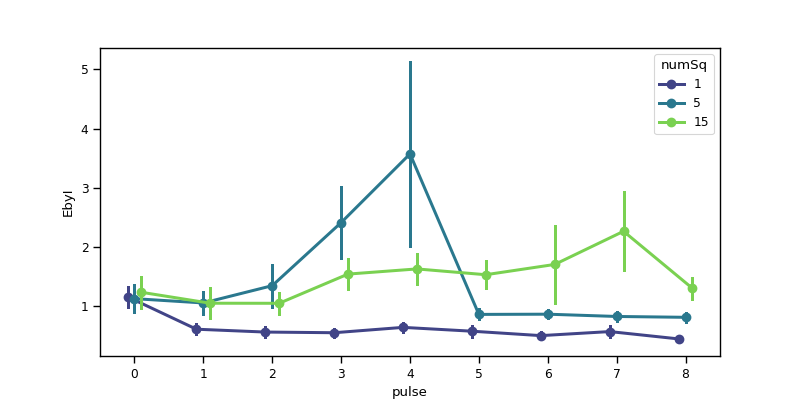

In [29]:
# box plot of delayEI across numSq and stimFreq
fig3bs10, ax3s10 = plt.subplots(1,1, figsize=(8,4))
sns.pointplot(data=ebyi_df, x='pulse', y='EbyI', hue='numSq', hue_order=[1,5,15], ax=ax3s10, palette=color_squares, errorbar='se', dodge=0.2)
# save fig
fig3bs10.savefig(paper_figure_export_location / 'Figure3s10_EbyI_vs_pulse_vsnumsq.png', dpi=300, bbox_inches='tight')
fig3bs10.savefig(paper_figure_export_location / 'Figure3s10_EbyI_vs_pulse_vsnumsq.svg', dpi=300, bbox_inches='tight')

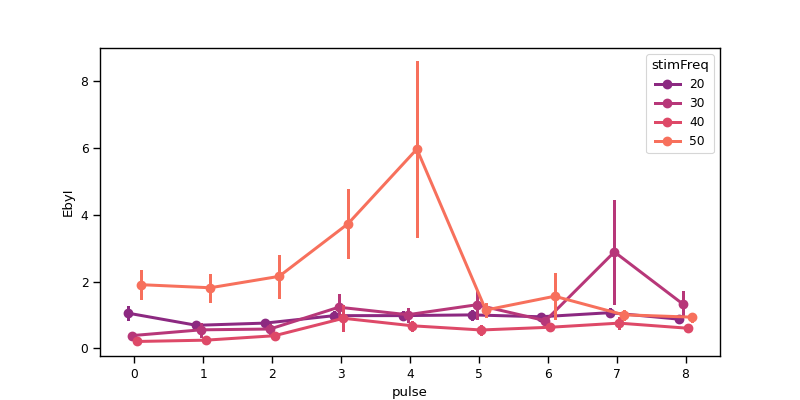

In [30]:
# box plot of delayEI across numSq and stimFreq
fig3bs11, ax3s11 = plt.subplots(1,1, figsize=(8,4))
sns.pointplot(data=ebyi_df, x='pulse', y='EbyI', hue='stimFreq', hue_order=[20,30,40,50], ax=ax3s11, palette=color_freq, errorbar='se', dodge=0.2)
# save fig
fig3bs10.savefig(paper_figure_export_location / 'Figure3s10_EbyI_vs_pulse_vsstimFreq.png', dpi=300, bbox_inches='tight')
fig3bs10.savefig(paper_figure_export_location / 'Figure3s10_EbyI_vs_pulse_vsstimFreq.svg', dpi=300, bbox_inches='tight')

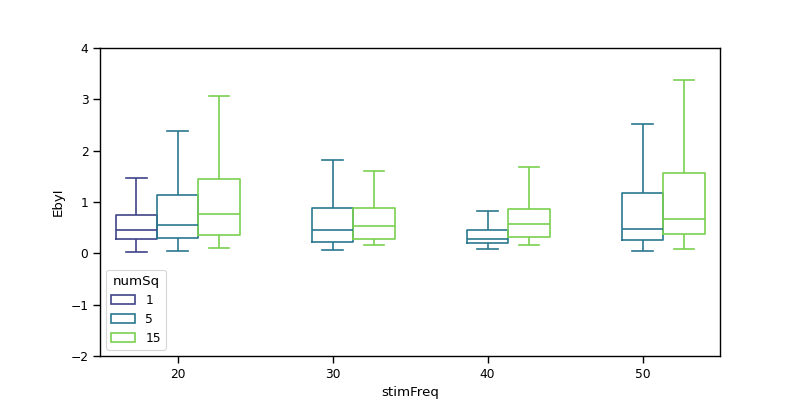

In [31]:
# box plot of EbyI across numSq and stimFreq
fig3s12, ax3bs12 = plt.subplots(1,1, figsize=(8,4))
sns.boxplot(data=ebyi_df, x='stimFreq', y='EbyI', hue='numSq', hue_order=[1,5,15], dodge=True, ax=ax3bs12, palette=color_squares, fliersize=0, fill=False)
ax3bs12.set_ylim([-2,4])
# sns.stripplot(data=ebyi_df, x='stimFreq', y='EbyI', hue='numSq', hue_order=[1,5,15], dodge=True, ax=ax3bs12, palette=color_squares, linewidth=0.1, alpha=0.5)
#save fig
fig3s12.savefig(paper_figure_export_location / 'Figure3s12_EbyI_vsfreq_vsnumsq.png', dpi=300, bbox_inches='tight')
fig3s12.savefig(paper_figure_export_location / 'Figure3s12_EbyI_vsfreq_vsnumsq.svg', dpi=300, bbox_inches='tight')

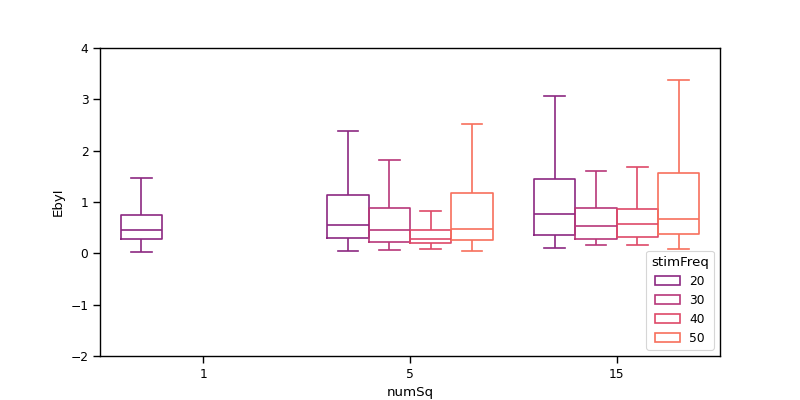

In [32]:
# box plot of delayEI across numSq and stimFreq
fig3s13, ax3s13 = plt.subplots(1,1, figsize=(8,4))
sns.boxplot(data=ebyi_df, x='numSq', y='EbyI', hue='stimFreq', dodge=True, ax=ax3s13, palette=color_freq, fliersize=0, fill=False)
ax3s13.set_ylim([-2,4])
# sns.stripplot(data=ebyi_df, x='numSq', y='EbyI', hue='stimFreq', dodge=True, ax=ax3s13, palette=color_freq, linewidth=0.1, alpha=0.5)
# save fig
fig3s13.savefig(paper_figure_export_location / 'Figure3s13_EbyI_vsnumsq_vsstimFreq.png', dpi=300, bbox_inches='tight')
fig3s13.savefig(paper_figure_export_location / 'Figure3s13_EbyI_vsnumsq_vsstimFreq.svg', dpi=300, bbox_inches='tight')